In [1]:
import random
import time

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

# Set seeds
seed = 69
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")

The device is set to: cuda


# Task 1: Data Preprocessing

## Remove missing values and duplicates entries

In [2]:
# Import dataset
data = pd.read_csv("dataset_lab_1.csv")

# Remove duplicates
previous_length = len(data)
data = data.drop_duplicates()
actual_length = len(data)
print("Removed {} duplicates".format(previous_length - actual_length))

# Remove missing values
previous_length = len(data)
data = data.dropna()
actual_length = len(data)
print("Removed {} missing values".format(previous_length - actual_length))

Removed 2111 duplicates
Removed 3 missing values


## Ensure data consistency and correct formatting

In [3]:
# Remove infinite and negative values
previous_length = len(data)
data = data[(data.iloc[:, :-1] >= 0).all(axis=1) & np.isfinite(data.iloc[:, :-1]).all(axis=1)]
actual_length = len(data)
print("Removed {} infinite and negative values\n".format(previous_length - actual_length))

# Encoding label as integer
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(data['Label'])  # label encoding
print(str(data['Label'].value_counts()) + "\n")

# Print the label corresponding to encoded index
[ print(f"Class '{label}' has index {index}") for index, label in enumerate(label_encoder.inverse_transform(range(0,max(label_encoded)+1))) ]

Removed 9 infinite and negative values

Label
Benign         19240
PortScan        4849
DoS Hulk        3868
Brute Force     1427
Name: count, dtype: int64

Class 'Benign' has index 0
Class 'Brute Force' has index 1
Class 'DoS Hulk' has index 2
Class 'PortScan' has index 3


[None, None, None, None]

## Split the dataset

In [4]:
X = data.iloc[:, :-1].values # Remove label column
y = label_encoded # Numerical label column

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=seed)  # 60% of the data is used for training
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed) # The remaining 40% is split equally: 20% for validation and 20% for testing.

# Used for Task 3
X_test_copy = X_test.copy()

## Plots of min, max, mean, standard deviation

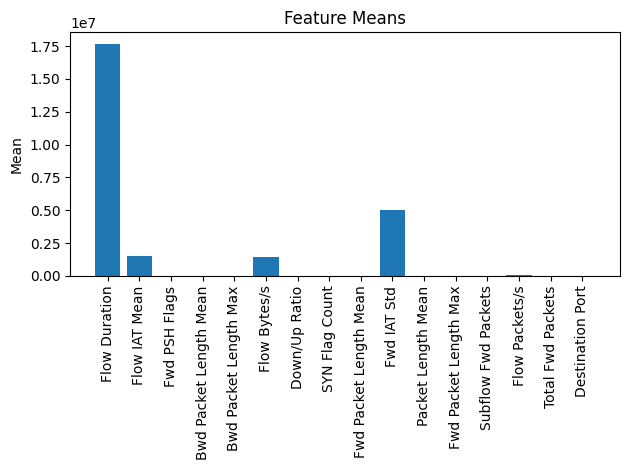

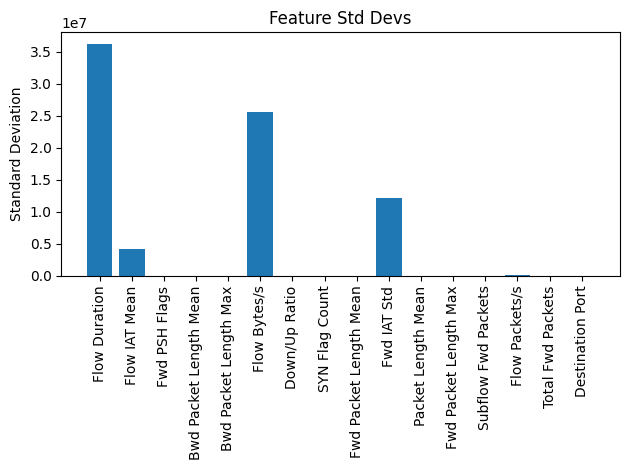

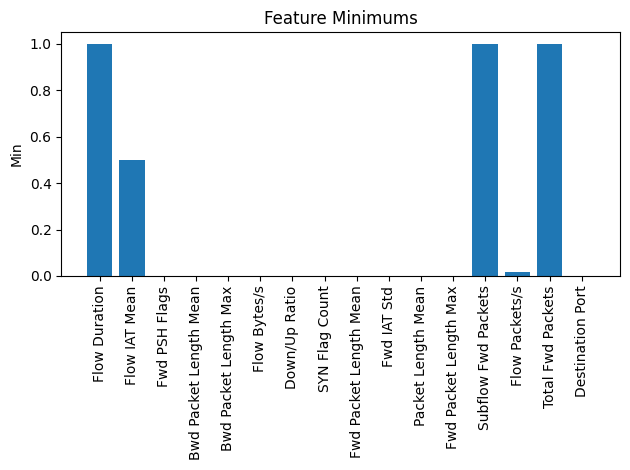

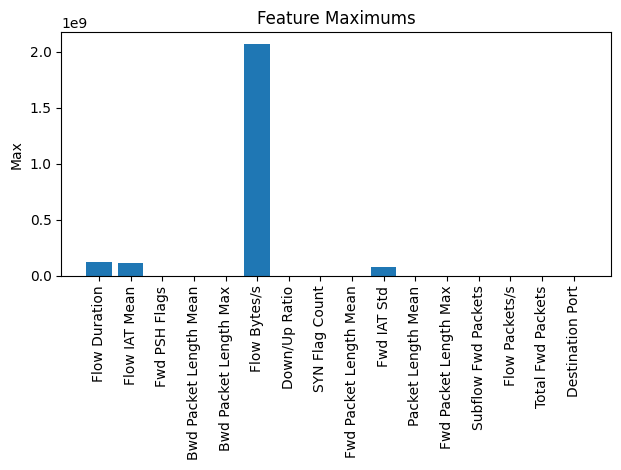

In [5]:
means = np.mean(X, axis=0)
stds = np.std (X, axis=0)
mins = np.min (X, axis=0)
maxs = np.max (X, axis=0)

# 2. Define a helper to plot one metric
def plot_metric(values, title, ylabel):
    plt.figure()
    plt.bar(data.columns[:-1], values)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# 3. Generate the four plots
plot_metric(means, "Feature Means", "Mean")
plot_metric(stds,  "Feature Std Devs", "Standard Deviation")
plot_metric(mins,  "Feature Minimums",   "Min")
plot_metric(maxs,  "Feature Maximums",   "Max")

## Standardization

In [6]:
# Standardize the features
# The mean and the standard deviation calculated on the training set is also used to standardize the validation and testing set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Task 2: Shallow Neural Network

## Define a simple linear model

In [7]:
class SimpleLinearModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLinearModel, self).__init__()
        self.hidden_linear = nn.Linear(input_size, hidden_size)
        self.output_linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden_linear(x)
        x = self.output_linear(x)
        return x

def training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs, patience=5, min_delta=0.001):
    start_time = time.time()
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    epochs_no_improvement = 0

    # Training loop
    for epoch in tqdm(range(num_epochs), desc="Training"):  # Train for epochs
        train_loss = 0
        val_loss = 0
        model.train()  # Set model to training mode
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move batch to GPU
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(batch_X)  # Forward pass
            loss = criterion(outputs, batch_y)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            train_loss += loss.item() * batch_X.size(0)
        train_loss /= len(train_dataset)
        train_losses.append(train_loss)  # Store training loss

        # Compute Validation loss during training
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for validation
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move batch to GPU
                val_outputs = model(batch_X)  # Forward pass
                loss = criterion(val_outputs, batch_y)  # Compute validation loss
                val_loss += loss.item() * batch_X.size(0)
            val_loss /= len(val_dataset)
            val_losses.append(val_loss)  # Store validation loss

        # Early stopping
        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            epochs_no_improvement = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Saving the best model
        else:
            epochs_no_improvement += 1
            if epochs_no_improvement >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs!')
                print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
                break  # Stop training

        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'The function took {elapsed_time:.2f} seconds to execute.')

    # Restore best model weights
    model.load_state_dict(torch.load('best_model.pth', map_location=device))

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    return

def testing_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the class with highest score
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100
    precision = precision_score(all_labels, all_predictions, average=None) * 100
    recall = recall_score(all_labels, all_predictions, average=None) * 100
    f1 = f1_score(all_labels, all_predictions, average=None) * 100

    return accuracy, precision, recall, f1, all_labels, all_predictions

def stats(accuracy, precision, recall, f1, description):
    print(f'{description} Accuracy: {accuracy:.4f}')
    print(f'{description} Precision Scores: {precision}')
    print(f'{description} Recall Scores: {recall}')
    print(f'{description} F1 Scores: {f1}\n')

## Create DataLoader

In [8]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Simple Linear Model with 32 neurons

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 20/100, Train Loss: 0.3401, Val Loss: 0.3216
Epoch 40/100, Train Loss: 0.3231, Val Loss: 0.3092
Early stopping triggered after 52 epochs!
Epoch 52/100, Train Loss: 0.3184, Val Loss: 0.3050
The function took 32.13 seconds to execute.


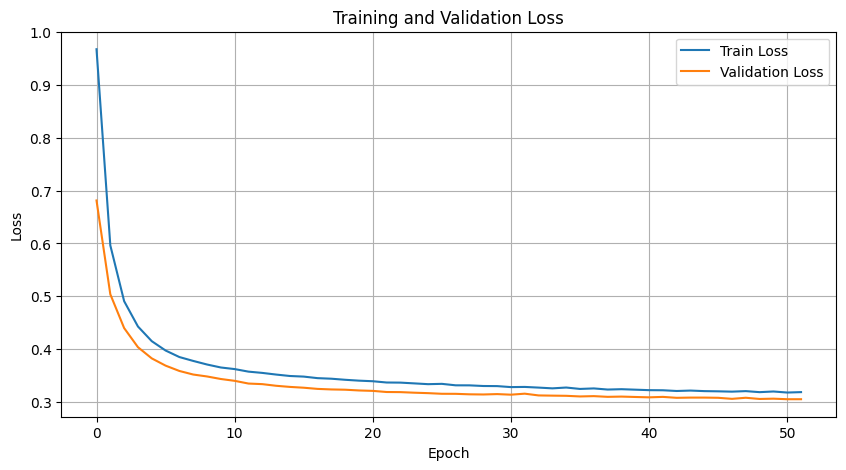

Training Accuracy: 88.4515
Training Precision Scores: [88.48100249  0.         98.38302173 83.29113924]
Training Recall Scores: [95.58313086  0.         84.68899522 89.22033898]
Training F1 Scores: [91.8950486   0.         91.02384292 86.15384615]

Validation Accuracy: 88.9570
Validation Precision Scores: [89.19768004  0.         98.1612447  82.24390244]
Validation Recall Scores: [95.49805951  0.         88.74680307 88.73684211]
Validation F1 Scores: [92.24040985  0.         93.21692411 85.36708861]

Test Accuracy: 88.5486
Test Precision Scores: [88.89426567  0.         98.68804665 81.70498084]
Test Recall Scores: [95.40379122  0.         86.02287166 89.88408851]
Test F1 Scores: [92.03406814  0.         91.92124915 85.5995986 ]



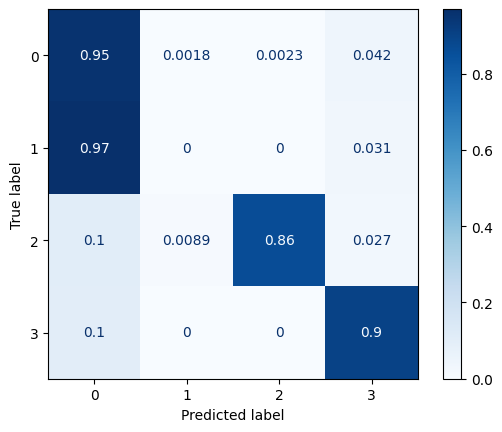

In [9]:
model = SimpleLinearModel(16, 32, 4)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
num_epochs = 100

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, _, _ = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, all_labels_test, all_predictions_test = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_test, all_predictions_test, normalize='true', cmap='Blues')

## Simple Linear Model with 64 neurons




Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 20/100, Train Loss: 0.3347, Val Loss: 0.3198
Epoch 40/100, Train Loss: 0.3202, Val Loss: 0.3071
Early stopping triggered after 41 epochs!
Epoch 41/100, Train Loss: 0.3202, Val Loss: 0.3099
The function took 23.80 seconds to execute.


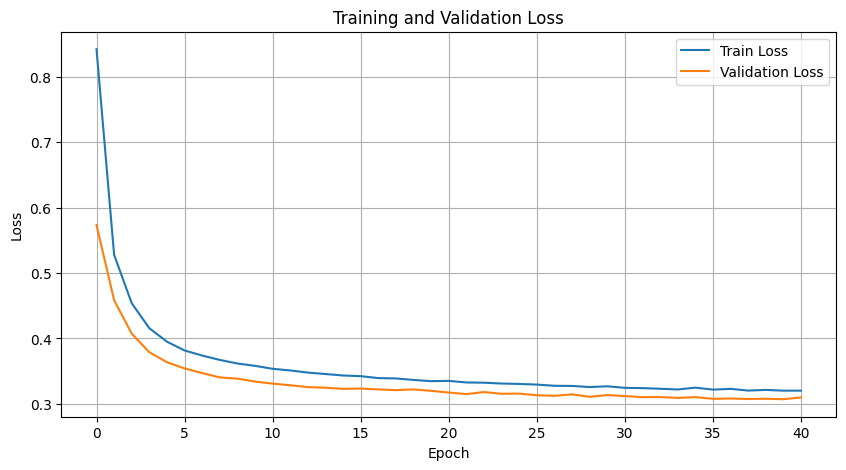

Training Accuracy: 88.3494
Training Precision Scores: [88.4488714   0.         98.18089944 83.00094967]
Training Recall Scores: [95.54842069  0.         84.51500652 88.88135593]
Training F1 Scores: [91.86167772  0.         90.83683964 85.8405631 ]

Validation Accuracy: 88.8038
Validation Precision Scores: [89.16565901  0.         97.88434415 81.67641326]
Validation Recall Scores: [95.39456662  0.         88.74680307 88.21052632]
Validation F1 Scores: [92.175       0.         93.09188464 84.81781377]

Test Accuracy: 88.5316
Test Precision Scores: [88.87814313  0.         98.68804665 81.65225744]
Test Recall Scores: [95.45572579  0.         86.02287166 89.56796628]
Test F1 Scores: [92.04958057  0.         91.92124915 85.42713568]



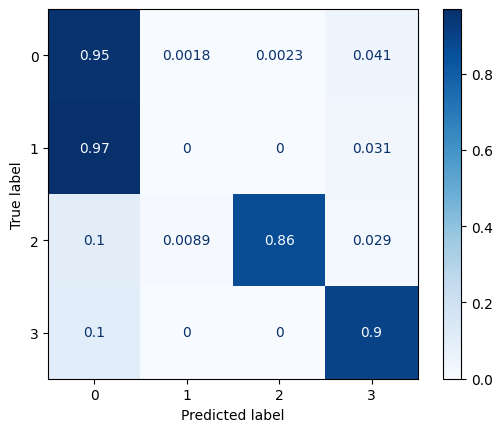

In [10]:
model = SimpleLinearModel(16, 64, 4)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
num_epochs = 100

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, _, _ = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, all_labels_test, all_predictions_test = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_test, all_predictions_test, normalize='true', cmap='Blues')

## Simple Linear Model with 128 neurons

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 20/100, Train Loss: 0.3288, Val Loss: 0.3129
Epoch 40/100, Train Loss: 0.3175, Val Loss: 0.3038
Early stopping triggered after 42 epochs!
Epoch 42/100, Train Loss: 0.3142, Val Loss: 0.3035
The function took 24.60 seconds to execute.


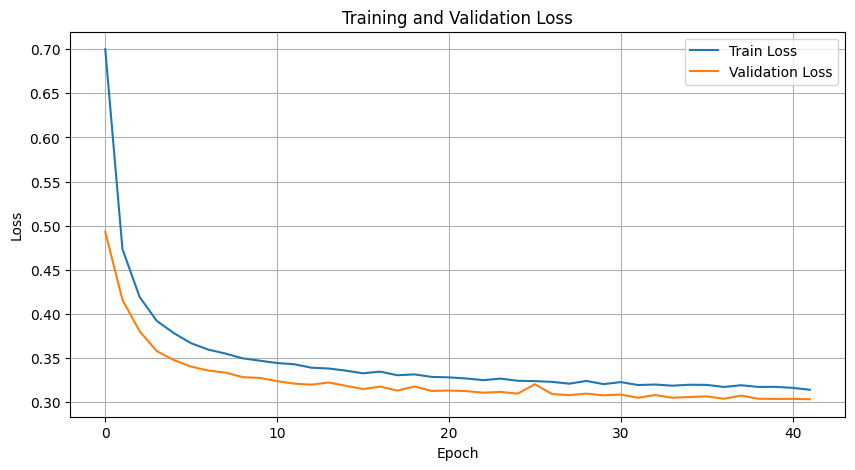

Training Accuracy: 88.6444
Training Precision Scores: [88.52472153  0.         98.33753149 84.15492958]
Training Recall Scores: [95.86081222  0.         84.90648108 89.11864407]
Training F1 Scores: [92.04682748  0.         91.12978525 86.56568983]

Validation Accuracy: 89.0761
Validation Precision Scores: [89.2159228   0.         98.44413013 82.53189401]
Validation Recall Scores: [95.67917206  0.         89.00255754 88.52631579]
Validation F1 Scores: [92.33458177  0.         93.48556078 85.42407313]

Test Accuracy: 88.7187
Test Precision Scores: [88.88353026  0.         98.68804665 82.62135922]
Test Recall Scores: [95.7153986   0.         86.02287166 89.67334036]
Test F1 Scores: [92.17304326  0.         91.92124915 86.00303183]



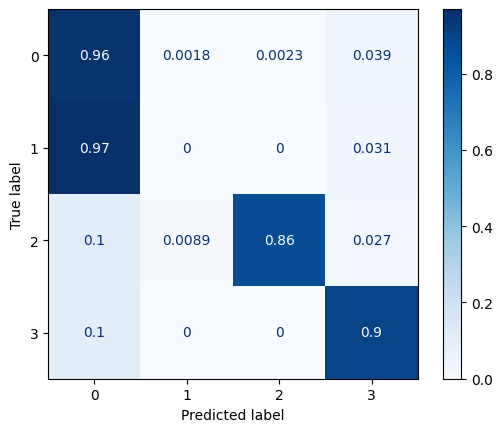

In [11]:
model = SimpleLinearModel(16, 128, 4)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
num_epochs = 100

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, _, _ = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, all_labels_test, all_predictions_test = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_test, all_predictions_test, normalize='true', cmap='Blues')

## Using ReLU as activation function

## Defining non linear model

In [12]:
class NonLinearModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NonLinearModel, self).__init__()
        self.hidden_linear = nn.Linear(input_size, hidden_size)
        self.output_linear = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden_linear(x))
        x = self.output_linear(x)
        return x

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 20/100, Train Loss: 0.1580, Val Loss: 0.1519
Epoch 40/100, Train Loss: 0.1371, Val Loss: 0.1336
Epoch 60/100, Train Loss: 0.1269, Val Loss: 0.1226
Early stopping triggered after 78 epochs!
Epoch 78/100, Train Loss: 0.1203, Val Loss: 0.1167
The function took 47.73 seconds to execute.


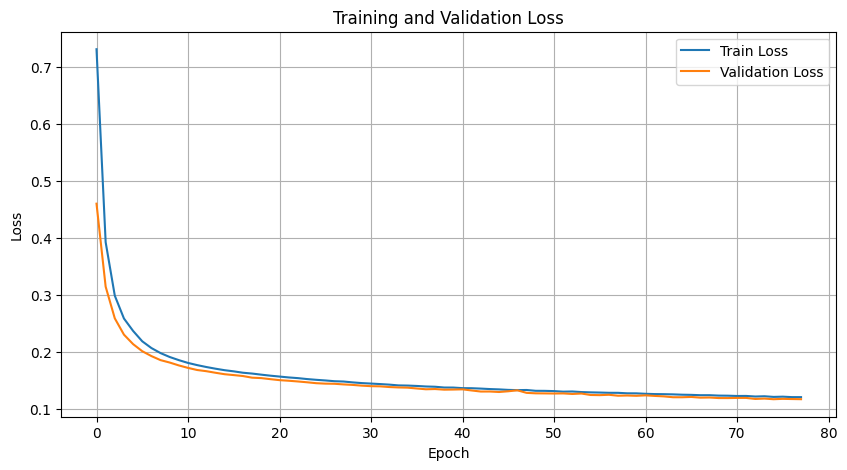

Training Accuracy: 95.2184
Training Precision Scores: [95.8989726  79.02439024 99.80741454 94.90870787]
Training Recall Scores: [97.19715377 94.51575263 90.16963897 91.62711864]
Training F1 Scores: [96.54369936 86.07863974 94.7440585  93.23904795]

Validation Accuracy: 95.6440
Validation Precision Scores: [96.43772424 80.73394495 99.44827586 94.58288191]
Validation Recall Scores: [97.36093144 94.28571429 92.19948849 91.89473684]
Validation F1 Scores: [96.89712888 86.98517298 95.68679496 93.21943406]

Test Accuracy: 95.6270
Test Precision Scores: [96.10954697 83.84146341 99.72105997 94.59459459]
Test Recall Scores: [97.507141   94.82758621 90.85133418 92.20231823]
Test F1 Scores: [96.80329982 88.99676375 95.07978723 93.38313767]



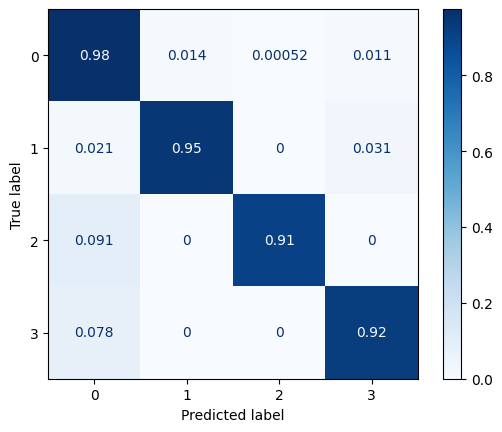

In [13]:
model = NonLinearModel(16, 128, 4)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
num_epochs = 100

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, _, _ = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, all_labels_test, all_predictions_test = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_test, all_predictions_test, normalize='true', cmap='Blues')

# Task 3: The impact of specific features

##  Replace port 80 with port 8080

In [14]:
X_test = pd.DataFrame(X_test_copy).assign(Label=y_test)  # Add label column
X_test.loc[(X_test[15] == 80) & (X_test['Label'] == 1), 15] = 8080  # Replace port 80 with 8080
X_test = X_test.iloc[:, :-1]  # Remove label column
X_test = scaler.transform(X_test)  # Standardized data based on training set mean and standard deviation

# Convert data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Testing the previously trained model

Test Accuracy: 91.2711
Test Precision Scores: [90.19937545 26.38888889 99.72105997 94.59459459]
Test Recall Scores: [97.507141    6.55172414 90.85133418 92.20231823]
Test F1 Scores: [93.71100574 10.49723757 95.07978723 93.38313767]



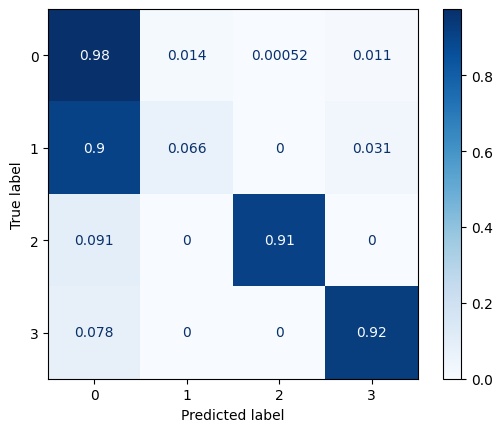

In [15]:
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, all_labels_test, all_predictions_test = testing_model(model,test_loader,device)
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')
ConfusionMatrixDisplay.from_predictions(all_labels_test, all_predictions_test, normalize='true', cmap='Blues')

## Remove the feature port from the original dataset

In [16]:
# Import dataset
data = pd.read_csv("dataset_lab_1.csv")
data = data.drop(columns=['Destination Port']) # Dropping the destination port feature

# Remove duplicates
previous_length = len(data)
data = data.drop_duplicates()
actual_length = len(data)
print("Removed {} duplicates".format(previous_length - actual_length))

# Remove missing values
previous_length = len(data)
data = data.dropna()
actual_length = len(data)
print("Removed {} missing values".format(previous_length - actual_length))

# Remove infinite and negative values
previous_length = len(data)
data = data[(data.iloc[:, :-1] >= 0).all(axis=1) & np.isfinite(data.iloc[:, :-1]).all(axis=1)]
actual_length = len(data)
print("Removed {} infinite and negative values\n".format(previous_length - actual_length))

# Encoding label as integer
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(data['Label'])  # label encoding
print(str(data['Label'].value_counts()) + "\n")

# Print the label corresponding to encoded index
[ print(f"Class '{label}' has index {index}") for index, label in enumerate(label_encoder.inverse_transform(range(0,max(label_encoded)+1))) ]

X = data.iloc[:, :-1].values # Remove label column
y = label_encoded # Numerical label column

# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=seed)  # 60% of the data is used for training
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed) # The remaining 40% is split equally: 20% for validation and 20% for testing.

# Standardize the features
# The mean and the standard deviation calculated on the training set is also used to standardize the validation and testing set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Removed 9031 duplicates
Removed 2 missing values
Removed 6 infinite and negative values

Label
Benign         16888
DoS Hulk        3868
Brute Force     1427
PortScan         285
Name: count, dtype: int64

Class 'Benign' has index 0
Class 'Brute Force' has index 1
Class 'DoS Hulk' has index 2
Class 'PortScan' has index 3


## Training the model

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 20/100, Train Loss: 0.1583, Val Loss: 0.1546
Epoch 40/100, Train Loss: 0.1337, Val Loss: 0.1346
Early stopping triggered after 50 epochs!
Epoch 50/100, Train Loss: 0.1276, Val Loss: 0.1302
The function took 23.73 seconds to execute.


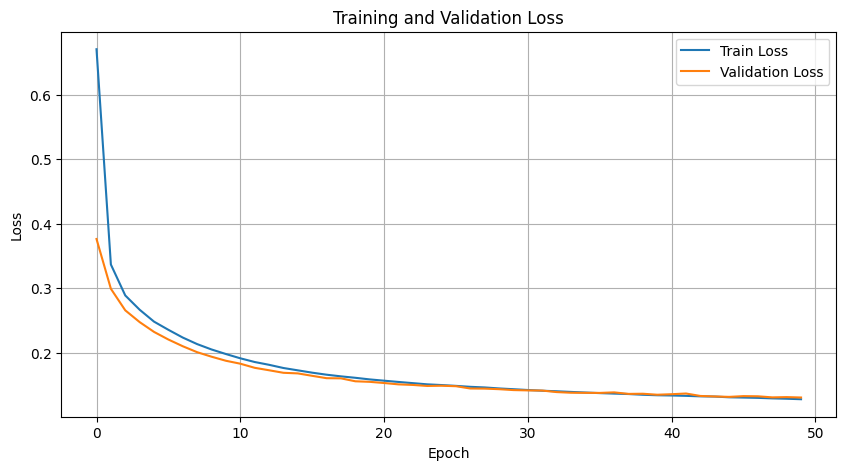

Training Accuracy: 94.4585
Training Precision Scores: [95.27657528 79.55854127 99.54773869 35.8490566 ]
Training Recall Scores: [97.59558534 94.74285714 86.7717915  10.91954023]
Training F1 Scores: [96.42213893 86.48930621 92.72174117 16.74008811]

Validation Accuracy: 94.9266
Validation Precision Scores: [95.44274589 81.26984127 99.85673352 28.57142857]
Validation Recall Scores: [98.10257931 92.75362319 88.11630847  7.40740741]
Validation F1 Scores: [96.75438596 86.63282572 93.61987911 11.76470588]

Test Accuracy: 94.8153
Test Precision Scores: [95.34816527 81.23076923 99.56834532 38.46153846]
Test Recall Scores: [98.01009801 95.65217391 87.15365239  8.77192982]
Test F1 Scores: [96.66080844 87.85357737 92.94828744 14.28571429]



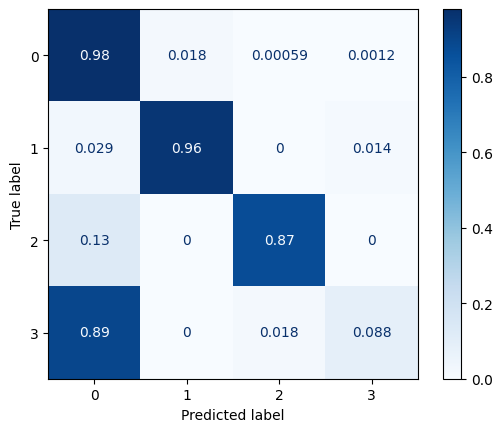

In [17]:
model = NonLinearModel(15, 128, 4)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
num_epochs = 100

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, _, _ = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, all_labels_test, all_predictions_test = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_test, all_predictions_test, normalize='true', cmap='Blues')

## Using a weighted loss

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 20/100, Train Loss: 0.2641, Val Loss: 0.2663
Epoch 40/100, Train Loss: 0.2163, Val Loss: 0.2371
Early stopping triggered after 52 epochs!
Epoch 52/100, Train Loss: 0.2052, Val Loss: 0.2343
The function took 24.89 seconds to execute.


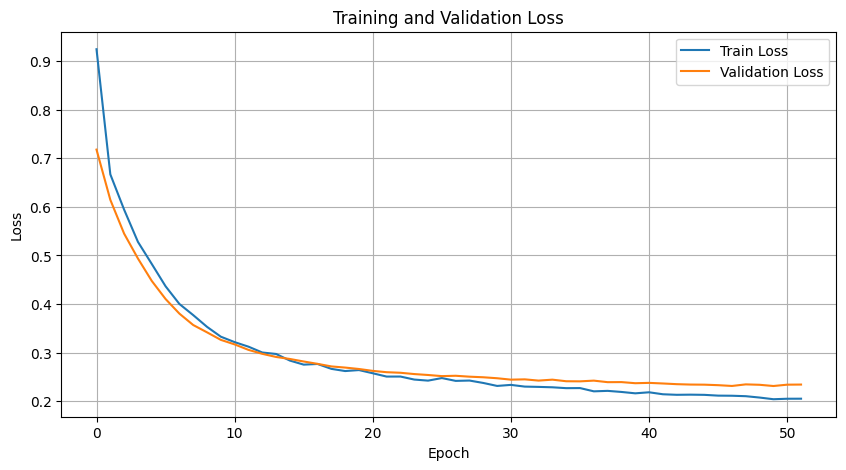

Training Accuracy: 91.1647
Training Precision Scores: [98.87967252 75.38601272 91.2688172  20.49286641]
Training Recall Scores: [90.45132046 94.85714286 92.9478756  90.8045977 ]
Training F1 Scores: [94.47789615 84.00809717 92.10069444 33.43915344]

Validation Accuracy: 91.2995
Validation Precision Scores: [98.80297638 74.85549133 91.12207152 20.73170732]
Validation Recall Scores: [90.54254373 93.84057971 93.42604298 94.44444444]
Validation F1 Scores: [94.49257426 83.27974277 92.25967541 34.        ]

Test Accuracy: 91.2995
Test Precision Scores: [98.67141931 76.74418605 91.14391144 21.11553785]
Test Recall Scores: [90.43659044 95.65217391 93.32493703 92.98245614]
Test F1 Scores: [94.37470944 85.16129032 92.2215308  34.41558442]



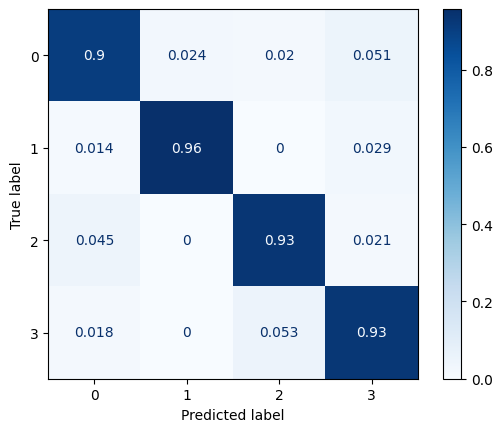

In [18]:
model = NonLinearModel(15, 128, 4)
model = model.to(device)
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)  # Computing class weights
class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)  # Converting to PyTorch tensor
criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
num_epochs = 100

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, _, _ = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, all_labels_test, all_predictions_test = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_test, all_predictions_test, normalize='true', cmap='Blues')

# Task 4: Deep Neural Network

## Architecture 1

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.3648, Val Loss: 0.3444
Epoch 40/50, Train Loss: 0.2754, Val Loss: 0.2754
The function took 31.71 seconds to execute.


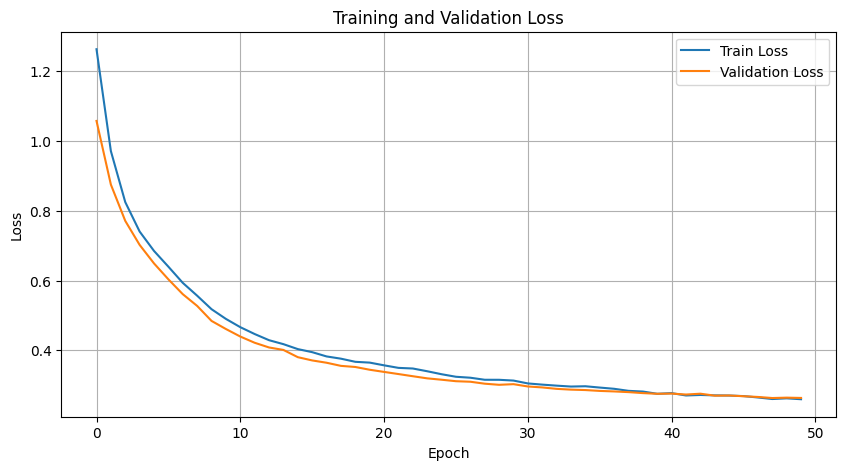

Training Accuracy: 91.9214
Training Precision Scores: [96.74738354 72.91116974 97.25085911 27.14285714]
Training Recall Scores: [92.91486007 94.74285714 86.7717915  87.35632184]
Training F1 Scores: [94.79239972 82.4055666  91.71296296 41.41689373]

Validation Accuracy: 91.9448
Validation Precision Scores: [97.02140863 71.03825137 96.40387275 26.37362637]
Validation Recall Scores: [92.70678921 94.20289855 88.11630847 88.88888889]
Validation F1 Scores: [94.81503942 80.99688474 92.07397622 40.6779661 ]

Test Accuracy: 92.1673
Test Precision Scores: [96.69956817 73.33333333 97.05469846 28.49162011]
Test Recall Scores: [93.10959311 95.65217391 87.15365239 89.47368421]
Test F1 Scores: [94.87063096 83.01886792 91.83808892 43.22033898]



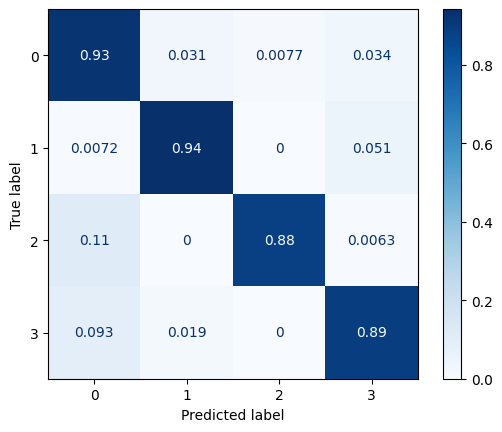

In [19]:
class DeepNonLinearModel_1(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepNonLinearModel_1, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = DeepNonLinearModel_1(15, 4)
model = model.to(device)
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)  # Computing class weights
class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)  # Converting to PyTorch tensor
criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
num_epochs = 50

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, all_labels_val, all_predictions_val = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, _, _ = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_val, all_predictions_val, normalize='true', cmap='Blues')

## Architecture 2

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.2413, Val Loss: 0.2635
Early stopping triggered after 29 epochs!
Epoch 29/50, Train Loss: 0.2250, Val Loss: 0.2548
The function took 18.49 seconds to execute.


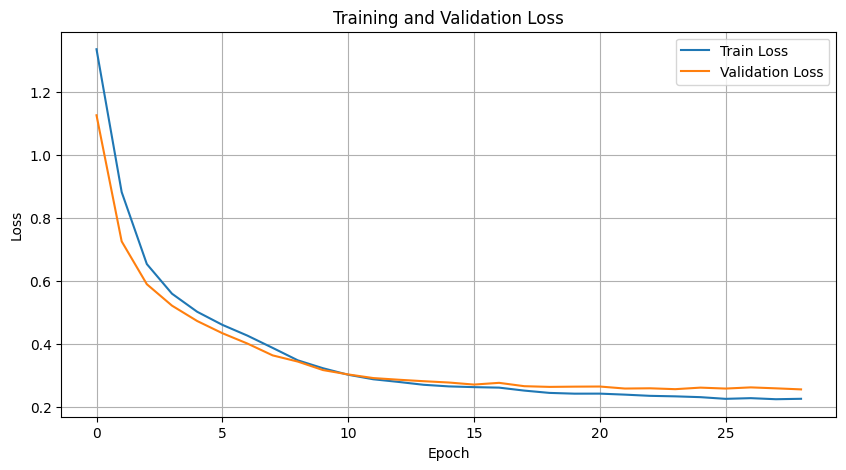

Training Accuracy: 90.6825
Training Precision Scores: [98.77506775 72.29965157 87.86628147 22.36842105]
Training Recall Scores: [89.79109184 94.85714286 93.25448971 87.93103448]
Training F1 Scores: [94.06906519 82.05635195 90.48023799 35.66433566]

Validation Accuracy: 90.6542
Validation Precision Scores: [98.6328125  71.94444444 87.20379147 22.47706422]
Validation Recall Scores: [89.83101097 93.84057971 93.04677623 90.74074074]
Validation F1 Scores: [94.02637704 81.44654088 90.03058104 36.02941176]

Test Accuracy: 90.9657
Test Precision Scores: [98.59889215 73.13019391 87.36842105 24.40191388]
Test Recall Scores: [89.87228987 95.65217391 94.08060453 89.47368421]
Test F1 Scores: [94.03356122 82.88854003 90.60036386 38.34586466]



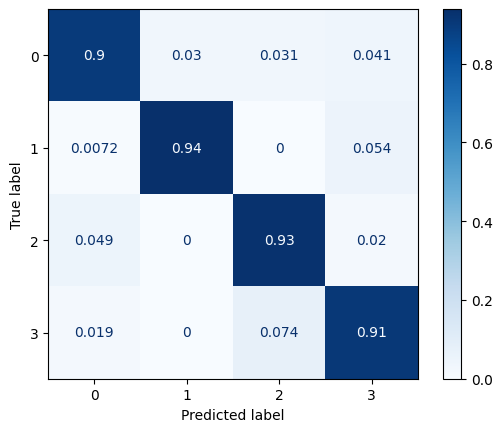

In [20]:
class DeepNonLinearModel_2(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepNonLinearModel_2, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = DeepNonLinearModel_2(15, 4)
model = model.to(device)
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)  # Computing class weights
class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)  # Converting to PyTorch tensor
criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
num_epochs = 50

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, all_labels_val, all_predictions_val = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, _, _ = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_val, all_predictions_val, normalize='true', cmap='Blues')

## Architecture 3

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.3474, Val Loss: 0.3186
Epoch 40/50, Train Loss: 0.2787, Val Loss: 0.2745
The function took 38.49 seconds to execute.


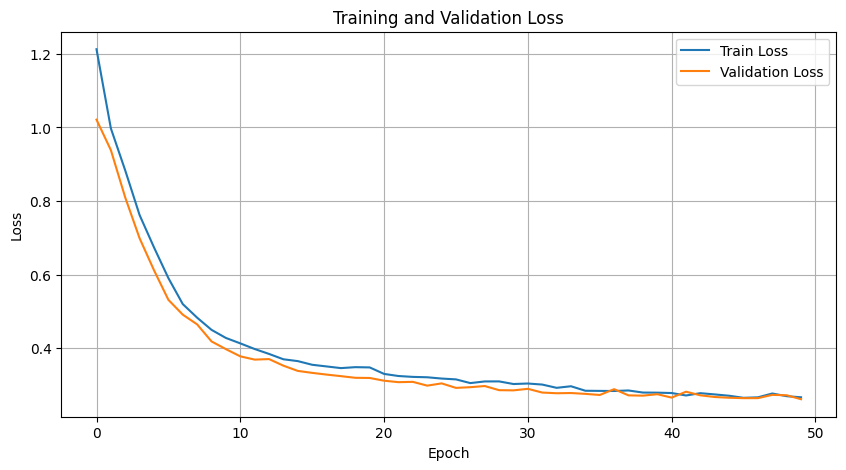

Training Accuracy: 92.3591
Training Precision Scores: [97.79304601 75.69913211 89.77176669 31.21019108]
Training Recall Scores: [92.56996453 89.71428571 93.03547963 84.48275862]
Training F1 Scores: [95.10985117 82.11297071 91.37448914 45.58139535]

Validation Accuracy: 92.6569
Validation Precision Scores: [97.90625    76.5625     89.46731235 31.75675676]
Validation Recall Scores: [92.8846724  88.76811594 93.42604298 87.03703704]
Validation F1 Scores: [95.32937776 82.2147651  91.40383426 46.53465347]

Test Accuracy: 93.0129
Test Precision Scores: [97.93878826 76.92307692 90.83129584 34.22818792]
Test Recall Scores: [93.13929314 90.57971014 93.5768262  89.47368421]
Test F1 Scores: [95.47876389 83.19467554 92.18362283 49.51456311]



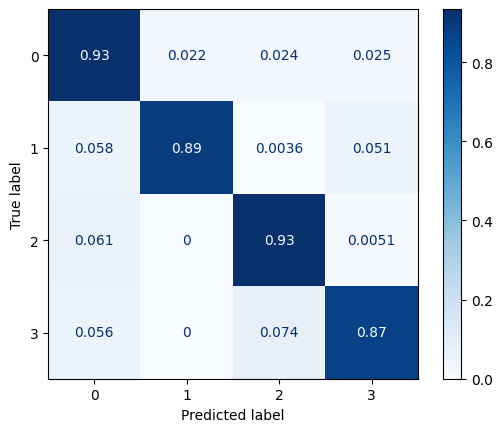

In [21]:
class DeepNonLinearModel_3(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepNonLinearModel_3, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 4)
        self.fc5 = nn.Linear(4, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

model = DeepNonLinearModel_3(15, 4)
model = model.to(device)
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)  # Computing class weights
class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)  # Converting to PyTorch tensor
criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
num_epochs = 50

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, all_labels_val, all_predictions_val = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, _, _ = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_val, all_predictions_val, normalize='true', cmap='Blues')

## The impact of batch size

In [22]:
# Set seeds
seed = 69
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

Batch_size 1:


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.1427, Val Loss: 0.1408
Early stopping triggered after 21 epochs!
Epoch 21/50, Train Loss: 0.1428, Val Loss: 0.1363
The function took 815.54 seconds to execute.


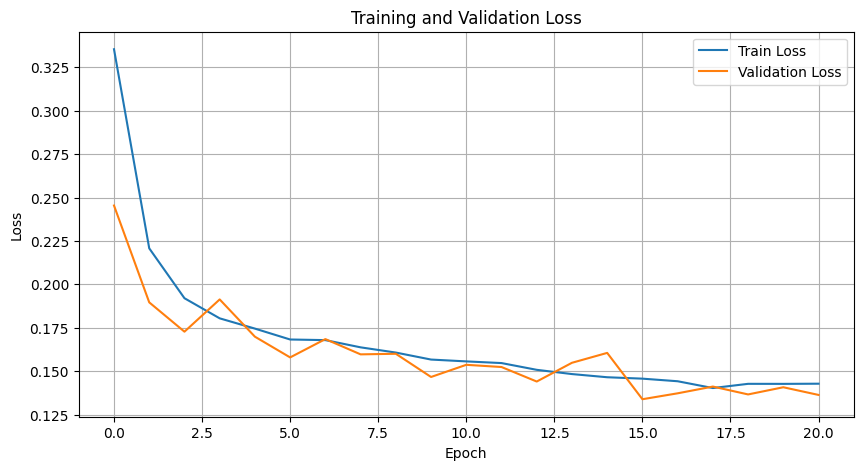

Training Accuracy: 94.4881
Training Precision Scores: [95.05652424 79.38638543 99.64841788 37.5       ]
Training Recall Scores: [97.77296019 94.62857143 86.90319755  1.72413793]
Training F1 Scores: [96.39560867 86.33993743 92.84043051  3.2967033 ]

Validation Accuracy: 94.9711
Validation Precision Scores: [ 95.25452977  81.32911392  99.71387697 100.        ]
Validation Recall Scores: [98.1915209  93.11594203 88.11630847  3.7037037 ]
Validation F1 Scores: [96.70072993 86.82432432 93.55704698  7.14285714]

Test Accuracy: 94.7263
Test Precision Scores: [95.18037518 80.73394495 99.14285714 50.        ]
Test Recall Scores: [97.95069795 95.65217391 87.40554156  1.75438596]
Test F1 Scores: [96.54566745 87.56218905 92.90495315  3.38983051]

Batch_size 32:


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.3270, Val Loss: 0.3578
Early stopping triggered after 35 epochs!
Epoch 35/50, Train Loss: 0.2954, Val Loss: 0.3560
The function took 46.10 seconds to execute.


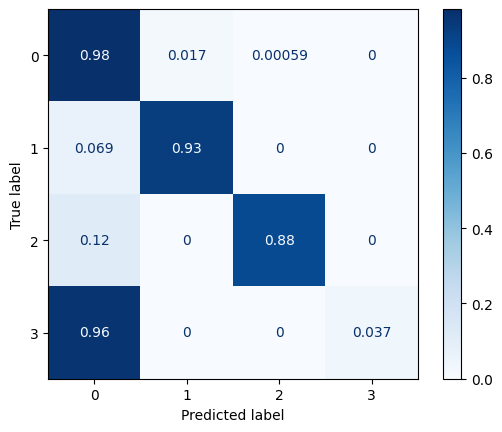

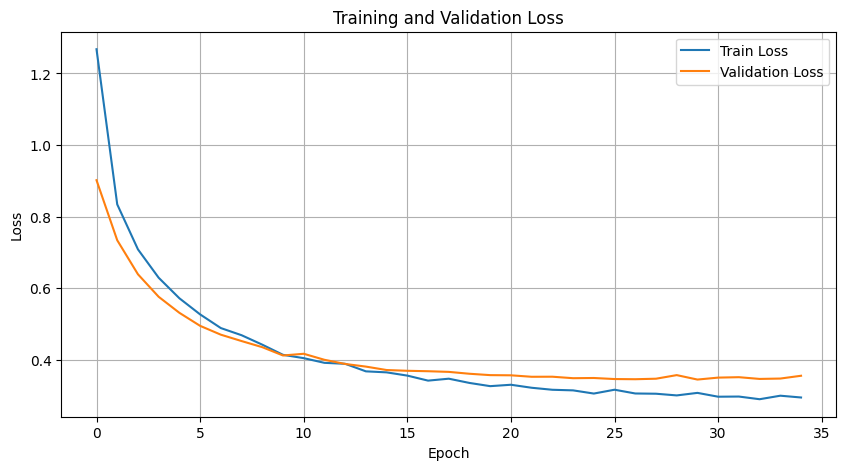

Training Accuracy: 89.0356
Training Precision Scores: [99.18195888 65.50907656 84.7826087  22.19354839]
Training Recall Scores: [88.41150966 94.85714286 88.8304862  98.85057471]
Training F1 Scores: [93.48754819 77.49766573 86.75935829 36.24868282]

Validation Accuracy: 89.0076
Validation Precision Scores: [99.23307769 64.83790524 82.38702202 22.94372294]
Validation Recall Scores: [88.23006226 94.20289855 89.88621997 98.14814815]
Validation F1 Scores: [93.4086629  76.80945347 85.97339782 37.19298246]

Test Accuracy: 89.4749
Test Precision Scores: [99.00793651 66.16541353 85.28347407 23.14049587]
Test Recall Scores: [88.92188892 95.65217391 89.04282116 98.24561404]
Test F1 Scores: [93.69425755 78.22222222 87.12261245 37.45819398]

Batch_size 64:


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.2889, Val Loss: 0.3183
Epoch 40/50, Train Loss: 0.2511, Val Loss: 0.2874
The function took 36.90 seconds to execute.


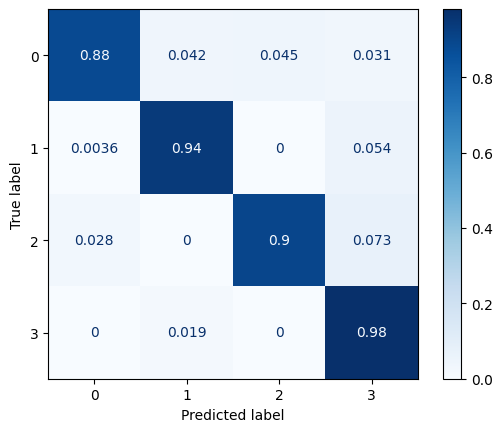

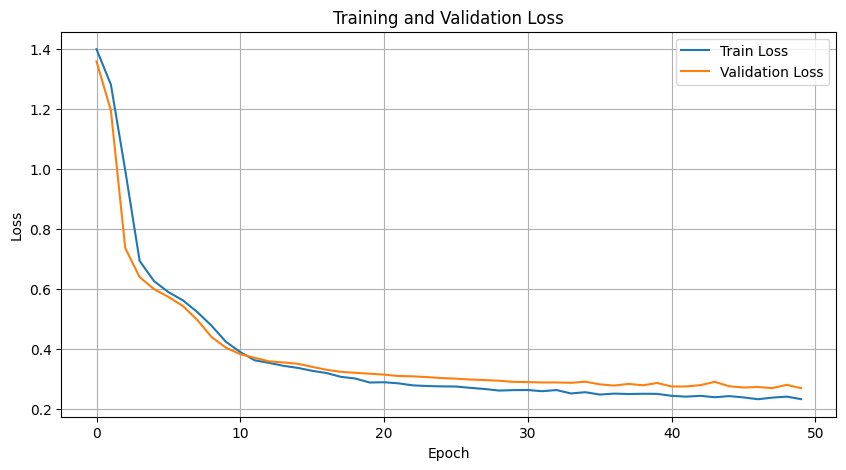

Training Accuracy: 90.3709
Training Precision Scores: [98.72427101 75.04520796 99.09954977 15.47277937]
Training Recall Scores: [90.74694521 94.85714286 86.7717915  93.10344828]
Training F1 Scores: [94.56767303 83.79606259 92.52685661 26.53562654]

Validation Accuracy: 90.3427
Validation Precision Scores: [98.64341085 74.         99.14407989 14.98559078]
Validation Recall Scores: [90.54254373 93.84057971 87.86346397 96.2962963 ]
Validation F1 Scores: [94.41953934 82.74760383 93.16353887 25.93516209]

Test Accuracy: 90.6542
Test Precision Scores: [98.55351977 76.08069164 99.13916786 15.63421829]
Test Recall Scores: [91.06029106 95.65217391 87.02770781 92.98245614]
Test F1 Scores: [94.65884532 84.75120385 92.68947015 26.76767677]

Batch_size 128:


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.3494, Val Loss: 0.3345
Epoch 40/50, Train Loss: 0.2861, Val Loss: 0.2773
The function took 22.65 seconds to execute.


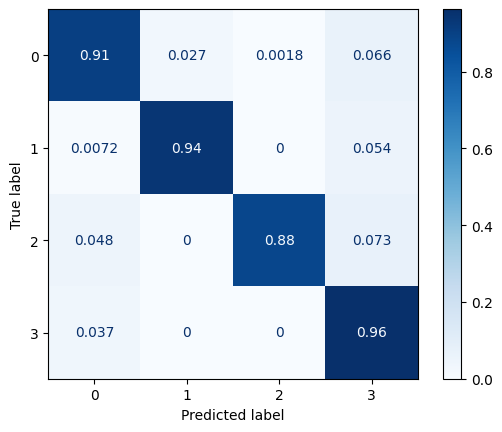

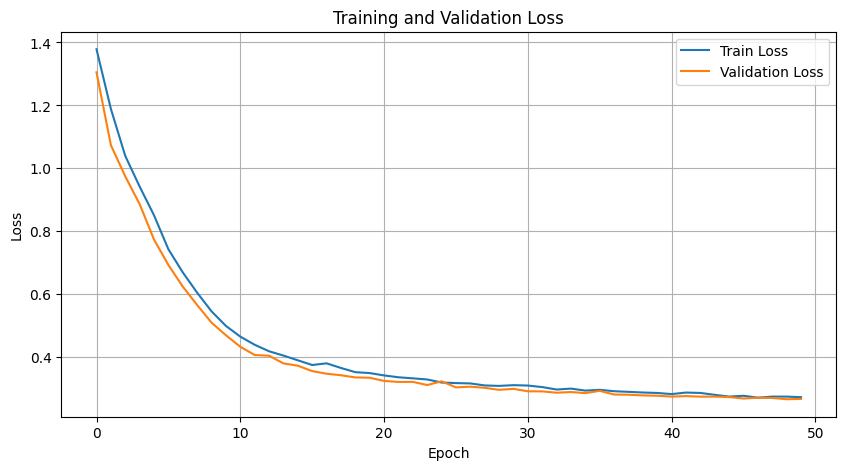

Training Accuracy: 89.6068
Training Precision Scores: [98.93534435 76.92307692 84.53768454 18.7654321 ]
Training Recall Scores: [87.90894758 94.85714286 95.31318441 87.35632184]
Training F1 Scores: [93.09679103 84.95394063 89.60263537 30.89430894]

Validation Accuracy: 89.4749
Validation Precision Scores: [98.89742733 78.72340426 83.87096774 17.58241758]
Validation Recall Scores: [87.75570709 93.84057971 95.32237674 88.88888889]
Validation F1 Scores: [92.99403079 85.61983471 89.23076923 29.35779817]

Test Accuracy: 89.8086
Test Precision Scores: [98.70173103 79.04191617 84.56375839 19.46564885]
Test Recall Scores: [88.06058806 95.65217391 95.21410579 89.47368421]
Test F1 Scores: [93.07800973 86.55737705 89.57345972 31.97492163]

Batch_size 512:


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.6690, Val Loss: 0.6395
Epoch 40/50, Train Loss: 0.3507, Val Loss: 0.3695
The function took 13.80 seconds to execute.


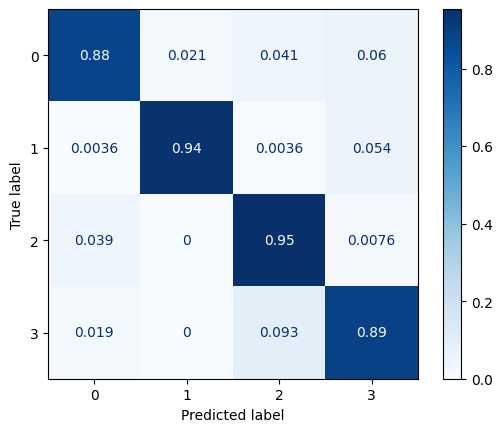

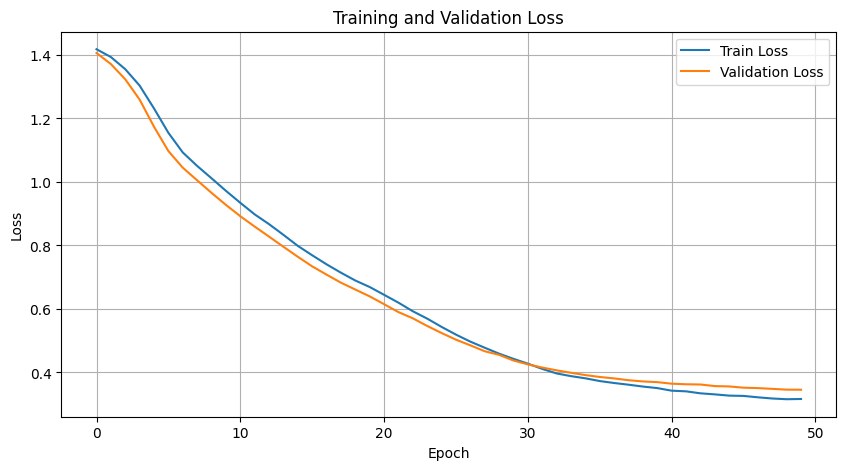

Training Accuracy: 86.1721
Training Precision Scores: [99.07396822 68.53265479 98.00895968 11.197411  ]
Training Recall Scores: [85.39613717 92.34285714 86.24616732 99.42528736]
Training F1 Scores: [91.72797036 78.67575463 91.75209692 20.12798138]

Validation Accuracy: 86.0481
Validation Precision Scores: [98.99965505 68.01075269 98.0141844  10.23166023]
Validation Recall Scores: [85.08745924 91.66666667 87.35777497 98.14814815]
Validation F1 Scores: [91.51785714 78.08641975 92.37967914 18.53146853]

Test Accuracy: 86.4709
Test Precision Scores: [98.86870072 68.16976127 98.15078236 11.06639839]
Test Recall Scores: [85.65488565 93.11594203 86.90176322 96.49122807]
Test F1 Scores: [91.78866964 78.7136294  92.18436874 19.85559567]



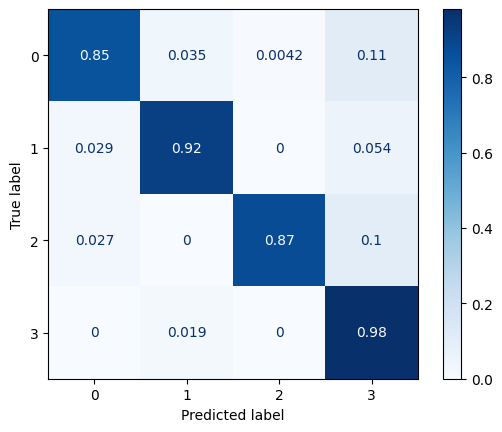

In [23]:
# The best is 128
for batch_size in [1, 32, 64, 128, 512]:
    print(f"Batch_size {batch_size}:")

    model = DeepNonLinearModel_3(15, 4) # Using the best architecture (architecture 3)
    model = model.to(device)
    class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)  # Computing class weights
    class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)  # Converting to PyTorch tensor
    criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    num_epochs = 50

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

    train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
    val_accuracy, val_precisionscores, val_recallscores, val_f1scores, all_labels_val, all_predictions_val = testing_model(model,val_loader,device)
    test_accuracy, test_precisionscores, test_recallscores, test_f1scores, _, _ = testing_model(model,test_loader,device)

    stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
    stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
    stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

    ConfusionMatrixDisplay.from_predictions(all_labels_val, all_predictions_val, normalize='true', cmap='Blues')

## The impact of activation function

### Linear activation function

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.4915, Val Loss: 0.5087
Early stopping triggered after 36 epochs!
Epoch 36/50, Train Loss: 0.4737, Val Loss: 0.5219
The function took 41.19 seconds to execute.


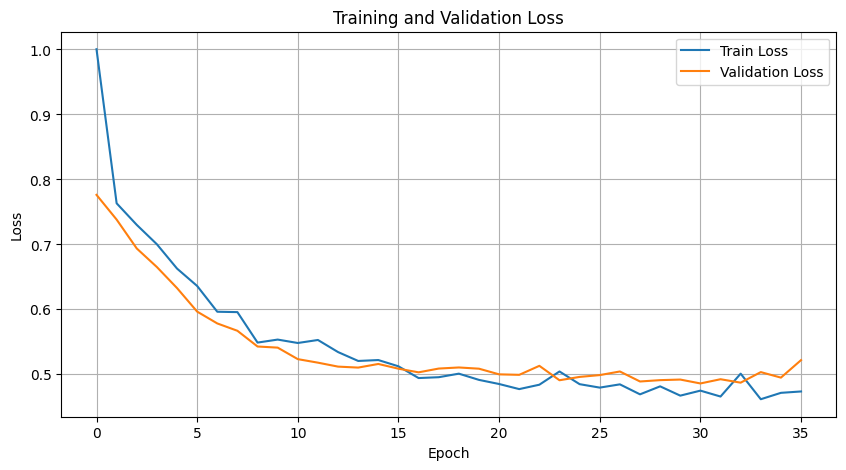

Training Accuracy: 81.2092
Training Precision Scores: [99.3691242  38.77952756 92.47412982 12.92407108]
Training Recall Scores: [79.15845487 90.05714286 86.11476128 91.95402299]
Training F1 Scores: [88.11978938 54.21396629 89.18122023 22.66288952]

Validation Accuracy: 81.1304
Validation Precision Scores: [99.40186916 36.55274889 94.00544959 12.37864078]
Validation Recall Scores: [78.83190039 89.13043478 87.23135272 94.44444444]
Validation F1 Scores: [87.92989418 51.84404636 90.49180328 21.88841202]

Test Accuracy: 81.8870
Test Precision Scores: [99.33505726 37.68768769 93.35142469 13.54166667]
Test Recall Scores: [79.86337986 90.94202899 86.64987406 91.22807018]
Test F1 Scores: [88.54132367 53.29087049 89.87589811 23.58276644]



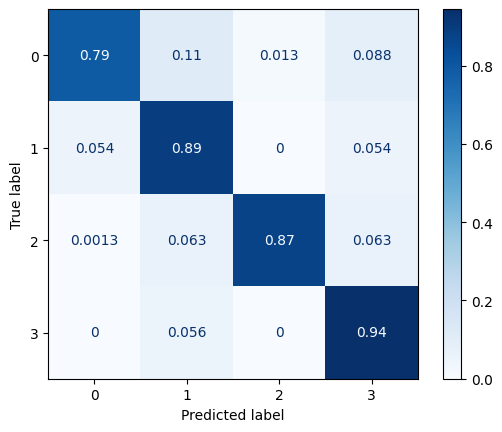

In [24]:
# Best architecture (number 3)
class DeepNonLinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepNonLinearModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 4)
        self.fc5 = nn.Linear(4, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return x

model = DeepNonLinearModel(15, 4)
model = model.to(device)
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)  # Computing class weights
class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)  # Converting to PyTorch tensor
criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
num_epochs = 50

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, all_labels_val, all_predictions_val = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, _, _ = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_val, all_predictions_val, normalize='true', cmap='Blues')

### Sigmoid activation function

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.9275, Val Loss: 0.9130
Epoch 40/50, Train Loss: 0.5860, Val Loss: 0.5879
The function took 65.56 seconds to execute.


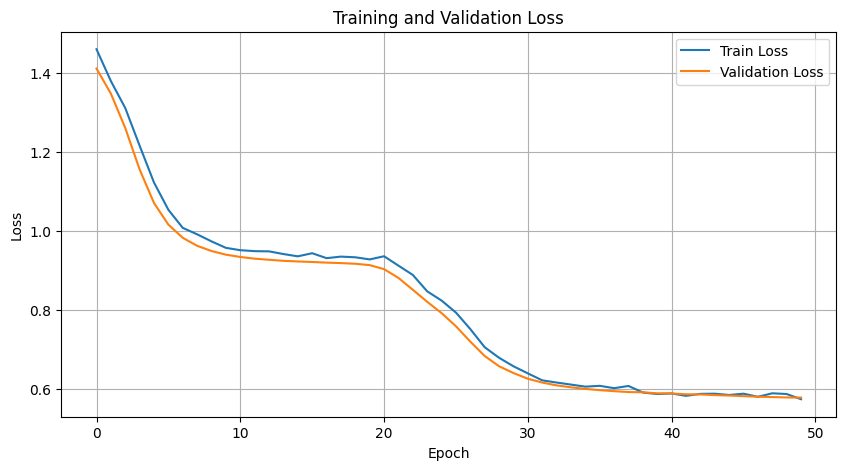

C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Accuracy: 93.4866
Training Precision Scores: [94.61982676 73.25256291 98.41348537  0.        ]
Training Recall Scores: [96.87623177 89.82857143 86.94699956  0.        ]
Training F1 Scores: [95.73473561 80.69815195 92.3255814   0.        ]

Validation Accuracy: 93.6582
Validation Precision Scores: [94.83309144 72.70029674 97.89325843  0.        ]
Validation Recall Scores: [96.85739698 88.76811594 88.11630847  0.        ]
Validation F1 Scores: [95.83455559 79.93474715 92.74783766  0.        ]

Test Accuracy: 93.5470
Test Precision Scores: [94.71237653 72.6744186  98.02259887  0.        ]
Test Recall Scores: [96.82209682 90.57971014 87.40554156  0.        ]
Test F1 Scores: [95.75561756 80.64516129 92.41011984  0.        ]



C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


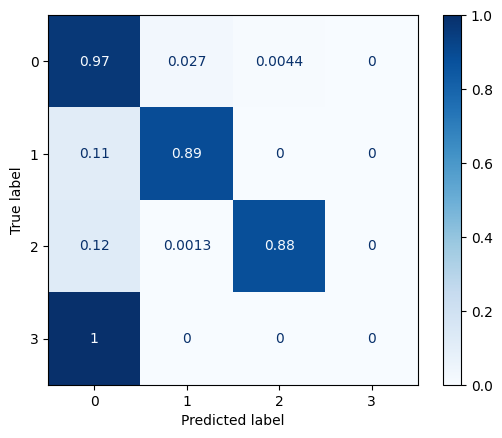

In [25]:
# Best architecture (number 3)
class DeepNonLinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepNonLinearModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 4)
        self.fc5 = nn.Linear(4, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        x = self.fc5(x)
        return x

model = DeepNonLinearModel(15, 4)
model = model.to(device)
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)  # Computing class weights
class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)  # Converting to PyTorch tensor
criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
num_epochs = 50

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, all_labels_val, all_predictions_val = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, _, _ = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_val, all_predictions_val, normalize='true', cmap='Blues')

### ReLU activation function

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.2400, Val Loss: 0.2340
Early stopping triggered after 36 epochs!
Epoch 36/50, Train Loss: 0.2071, Val Loss: 0.2263
The function took 47.69 seconds to execute.


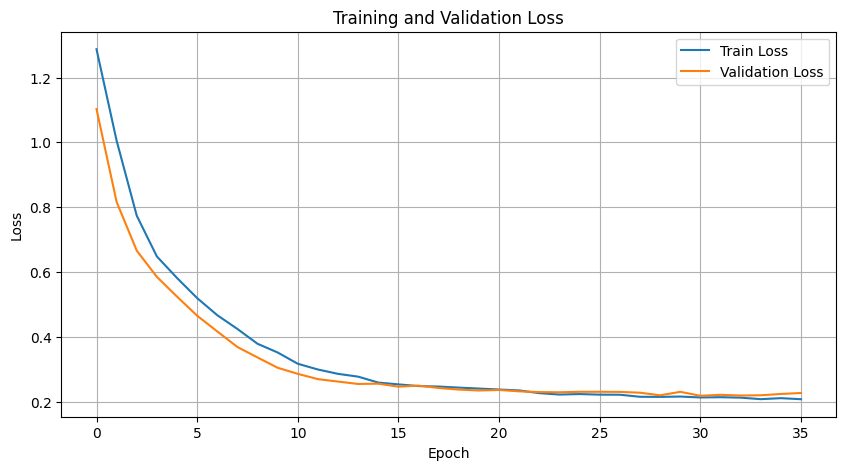

Training Accuracy: 92.1662
Training Precision Scores: [98.91013997 74.59605027 84.09703504 37.07317073]
Training Recall Scores: [91.21994482 94.97142857 95.66360053 87.35632184]
Training F1 Scores: [94.90951966 83.55957768 89.50819672 52.05479452]

Validation Accuracy: 91.8113
Validation Precision Scores: [98.80606647 72.95774648 82.91347207 37.79527559]
Validation Recall Scores: [90.77972132 93.84057971 95.70164349 88.88888889]
Validation F1 Scores: [94.62299135 82.09191759 88.84976526 53.03867403]

Test Accuracy: 92.0561
Test Precision Scores: [98.64821371 74.36619718 83.48017621 40.32258065]
Test Recall Scores: [91.03059103 95.65217391 95.46599496 87.71929825]
Test F1 Scores: [94.68643806 83.67670365 89.07168038 55.24861878]



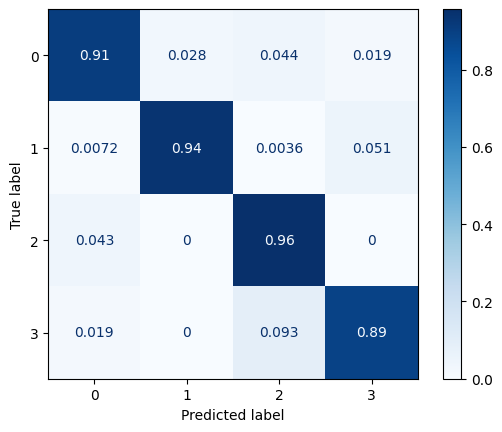

In [26]:
# Best architecture (number 3)
class DeepNonLinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepNonLinearModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 4)
        self.fc5 = nn.Linear(4, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

model = DeepNonLinearModel(15, 4)
model = model.to(device)
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)  # Computing class weights
class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)  # Converting to PyTorch tensor
criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
num_epochs = 50

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, all_labels_val, all_predictions_val = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, _, _ = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_val, all_predictions_val, normalize='true', cmap='Blues')

## The impact of the optimizer

### Stochastic Gradient Descent (SGD)

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 1.3705, Val Loss: 1.3632
Epoch 40/50, Train Loss: 1.3657, Val Loss: 1.3576
Early stopping triggered after 42 epochs!
Epoch 42/50, Train Loss: 1.3639, Val Loss: 1.3572
The function took 49.17 seconds to execute.


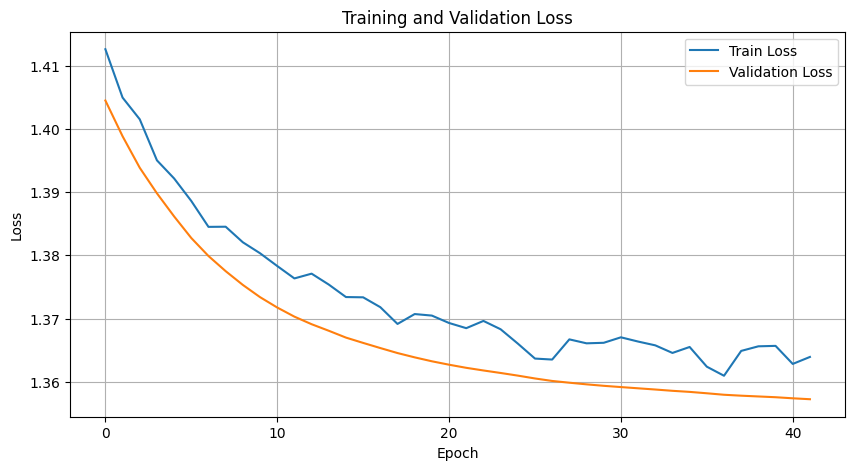

C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Accuracy: 62.4777
Training Precision Scores: [77.94510103  0.          8.16599732  0.        ]
Training Recall Scores: [80.58730784  0.         10.68769163  0.        ]
Training F1 Scores: [79.24418605  0.          9.25820527  0.        ]

Validation Accuracy: 61.3930
Validation Precision Scores: [76.88125894  0.          7.20720721  0.        ]
Validation Recall Scores: [79.66202194  0.          9.10240202  0.        ]
Validation F1 Scores: [78.24694234  0.          8.04469274  0.        ]

Test Accuracy: 62.1273
Test Precision Scores: [77.08925526  0.          8.19672131  0.        ]
Test Recall Scores: [80.54648055  0.         10.07556675  0.        ]
Test F1 Scores: [78.77995643  0.          9.03954802  0.        ]



C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


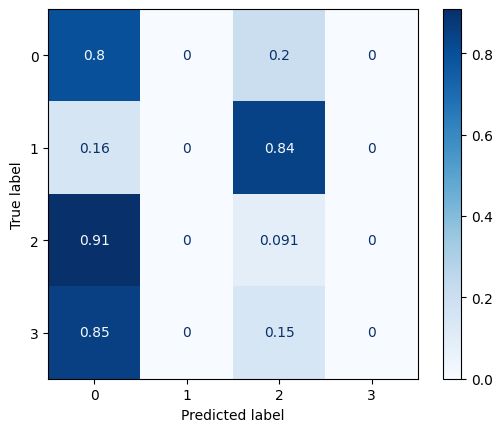

In [27]:
model = DeepNonLinearModel_3(15, 4)
model = model.to(device)
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)  # Computing class weights
class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)  # Converting to PyTorch tensor
criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.0005)
num_epochs = 50

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, all_labels_val, all_predictions_val = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, _, _ = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_val, all_predictions_val, normalize='true', cmap='Blues')

### SGD with Momentum (0.1, 0.5, 0.9)

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 1.3751, Val Loss: 1.3716
Epoch 40/50, Train Loss: 1.3481, Val Loss: 1.3411
The function took 60.13 seconds to execute.


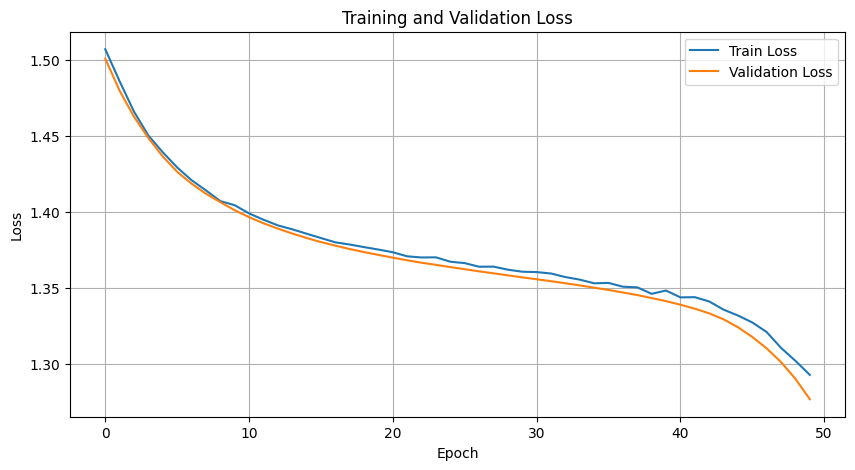

C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Momentum 0.1:
Training Accuracy: 77.8190
Training Precision Scores: [95.82203599 29.91556092 68.46127127  0.        ]
Training Recall Scores: [76.61608199 85.02857143 86.33377135  0.        ]
Training F1 Scores: [85.14949075 44.25936942 76.36574971  0.        ]

Validation Accuracy: 77.0138
Validation Precision Scores: [95.4870252  27.09302326 70.66666667  0.        ]
Validation Recall Scores: [75.27423658 84.42028986 87.10493047  0.        ]
Validation F1 Scores: [84.18435013 41.02112676 78.02944507  0.        ]

Test Accuracy: 77.7481
Test Precision Scores: [95.85511576 28.72727273 69.62663976  0.        ]
Test Recall Scores: [76.23997624 85.86956522 86.90176322  0.        ]
Test F1 Scores: [84.92969396 43.05177112 77.31092437  0.        ]



C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 1.1059, Val Loss: 1.0692
Epoch 40/50, Train Loss: 0.9491, Val Loss: 0.9214
The function took 60.38 seconds to execute.


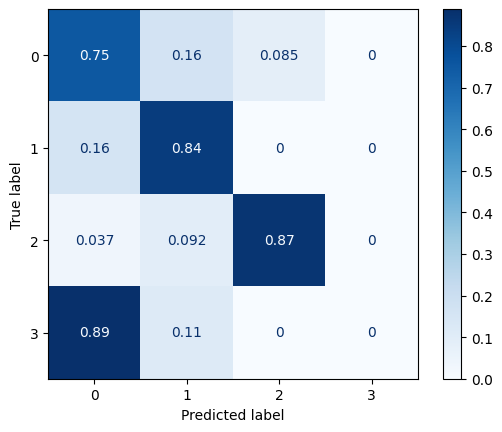

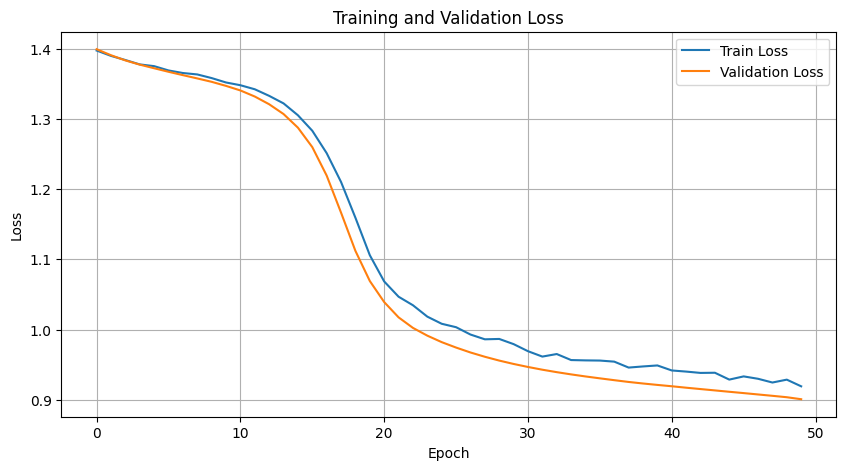

C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Momentum 0.5:
Training Accuracy: 87.2849
Training Precision Scores: [87.81034328  0.         85.2012116   0.        ]
Training Recall Scores: [96.54119038  0.         86.24616732  0.        ]
Training F1 Scores: [91.96902136  0.         85.72050501  0.        ]

Validation Accuracy: 87.8282
Validation Precision Scores: [88.27193933  0.         86.          0.        ]
Validation Recall Scores: [96.62021939  0.         86.97850822  0.        ]
Validation F1 Scores: [92.25760793  0.         86.48648649  0.        ]

Test Accuracy: 87.5834
Test Precision Scores: [88.20652174  0.         84.97536946  0.        ]
Test Recall Scores: [96.40629641  0.         86.90176322  0.        ]
Test F1 Scores: [92.12430822  0.         85.92777086  0.        ]



C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.7671, Val Loss: 0.7100
Epoch 40/50, Train Loss: 0.3115, Val Loss: 0.2798
The function took 59.14 seconds to execute.


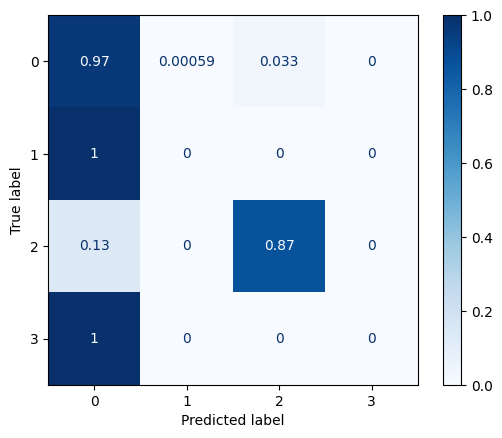

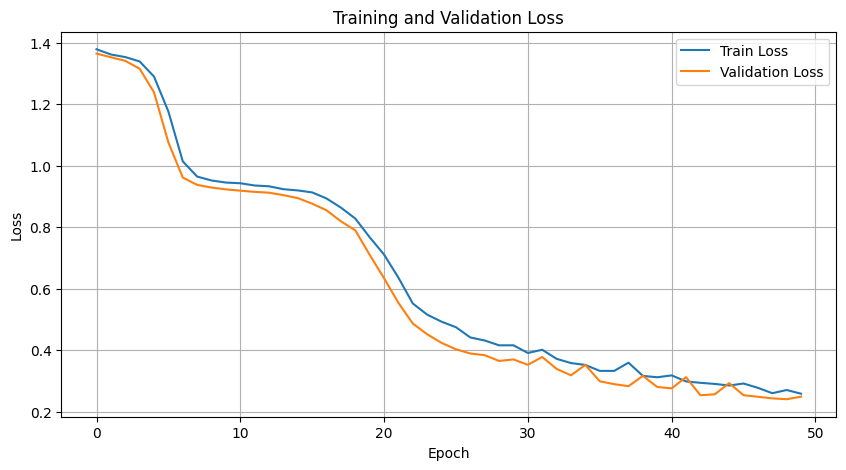

Momentum 0.9:
Training Accuracy: 92.9599
Training Precision Scores: [96.58231677 75.11312217 97.28395062 35.03480278]
Training Recall Scores: [94.402838   94.85714286 86.28996934 86.7816092 ]
Training F1 Scores: [95.48014153 83.83838384 91.45775302 49.91735537]

Validation Accuracy: 93.0574
Validation Precision Scores: [96.60503183 74.         96.35854342 36.64122137]
Validation Recall Scores: [94.48562111 93.84057971 86.97850822 88.88888889]
Validation F1 Scores: [95.53357314 82.74760383 91.42857143 51.89189189]

Test Accuracy: 93.1687
Test Precision Scores: [96.57056146 75.42857143 96.5034965  38.05970149]
Test Recall Scores: [94.50549451 95.65217391 86.90176322 89.47368421]
Test F1 Scores: [95.52686881 84.34504792 91.45129225 53.40314136]



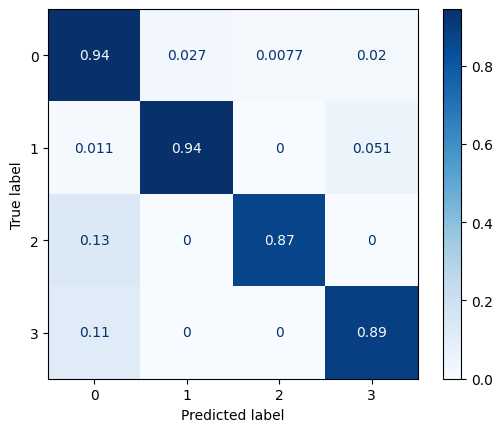

In [28]:
for momentum in [0.1, 0.5, 0.9]:
    model = DeepNonLinearModel_3(15, 4)
    model = model.to(device)
    class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)  # Computing class weights
    class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)  # Converting to PyTorch tensor
    criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
    optimizer = optim.SGD(model.parameters(), momentum=momentum,lr=0.0005)
    num_epochs = 50

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

    train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
    val_accuracy, val_precisionscores, val_recallscores, val_f1scores, all_labels_val, all_predictions_val = testing_model(model,val_loader,device)
    test_accuracy, test_precisionscores, test_recallscores, test_f1scores, _, _ = testing_model(model,test_loader,device)

    print(f"Momentum {momentum}:")

    stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
    stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
    stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

    ConfusionMatrixDisplay.from_predictions(all_labels_val, all_predictions_val, normalize='true', cmap='Blues')

### AdamW

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.2910, Val Loss: 0.2805
Early stopping triggered after 37 epochs!
Epoch 37/50, Train Loss: 0.2550, Val Loss: 0.2514
The function took 49.01 seconds to execute.


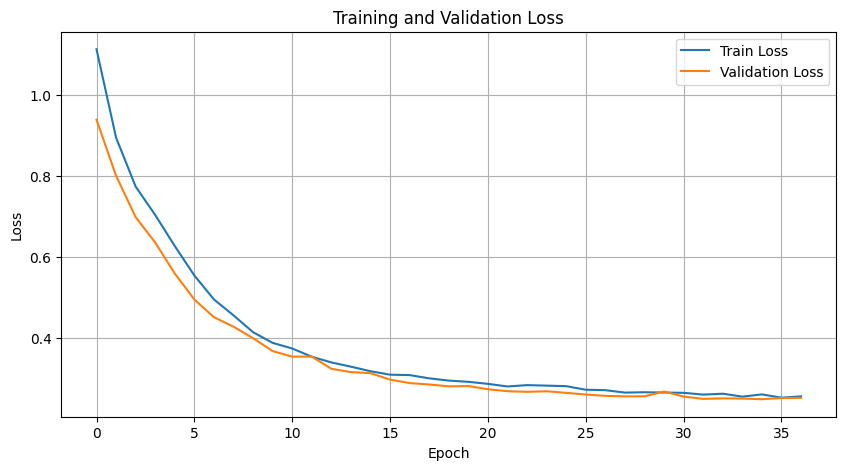

Training Accuracy: 92.8561
Training Precision Scores: [96.64680335 72.32375979 99.44331984 33.48017621]
Training Recall Scores: [94.29444225 94.97142857 86.07095926 87.35632184]
Training F1 Scores: [95.45613248 82.11462451 92.27518197 48.40764331]

Validation Accuracy: 93.1019
Validation Precision Scores: [96.81432039 71.23287671 99.56395349 33.10344828]
Validation Recall Scores: [94.6042099  94.20289855 86.59924147 88.88888889]
Validation F1 Scores: [95.69650622 81.12324493 92.63015551 48.24120603]

Test Accuracy: 93.2577
Test Precision Scores: [96.63432383 72.72727273 98.99425287 37.22627737]
Test Recall Scores: [94.65399465 95.65217391 86.77581864 89.47368421]
Test F1 Scores: [95.63390848 82.62910798 92.48322148 52.57731959]



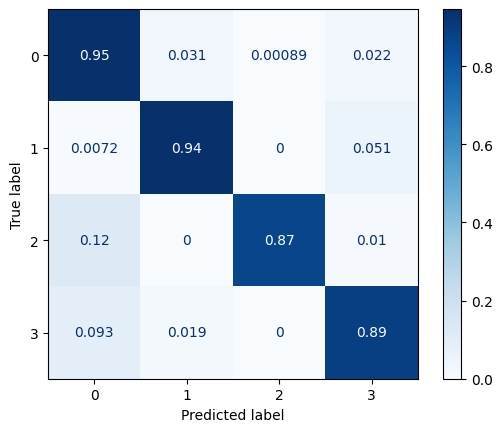

In [29]:
model = DeepNonLinearModel_3(15, 4)
model = model.to(device)
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)  # Computing class weights
class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)  # Converting to PyTorch tensor
criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
num_epochs = 50

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, all_labels_val, all_predictions_val = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, _, _ = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_val, all_predictions_val, normalize='true', cmap='Blues')

### AdamW with low learning rate

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 1.1844, Val Loss: 1.1555
Epoch 40/50, Train Loss: 1.0910, Val Loss: 1.0637
The function took 65.60 seconds to execute.


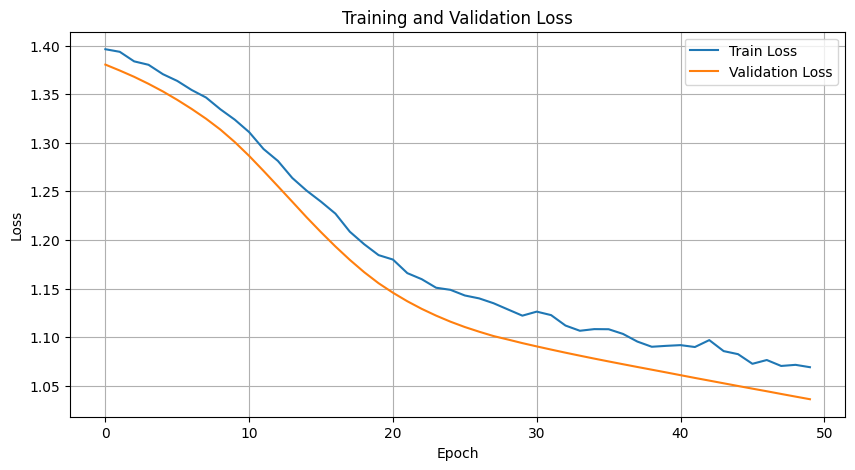

C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Accuracy: 81.1202
Training Precision Scores: [86.87602985  0.         62.34587417  0.        ]
Training Recall Scores: [88.32282223  0.         86.37757337  0.        ]
Training F1 Scores: [87.59345224  0.         72.42012486  0.        ]

Validation Accuracy: 82.3097
Validation Precision Scores: [87.49636522  0.         65.4028436   0.        ]
Validation Recall Scores: [89.2084198   0.         87.23135272  0.        ]
Validation F1 Scores: [88.34409865  0.         74.75622969  0.        ]

Test Accuracy: 82.0427
Test Precision Scores: [87.37609329  0.         64.84962406  0.        ]
Test Recall Scores: [89.01098901  0.         86.90176322  0.        ]
Test F1 Scores: [88.1859644   0.         74.27341227  0.        ]



C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


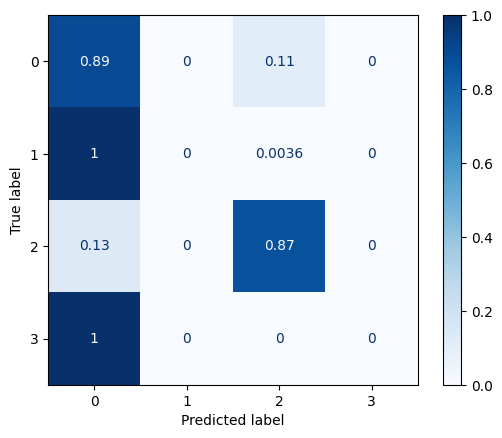

In [30]:
model = DeepNonLinearModel_3(15, 4)
model = model.to(device)
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)  # Computing class weights
class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)  # Converting to PyTorch tensor
criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.00001)
num_epochs = 50

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, all_labels_val, all_predictions_val = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, _, _ = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_val, all_predictions_val, normalize='true', cmap='Blues')

### AdamW with high learning rate

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Early stopping triggered after 9 epochs!
Epoch 9/50, Train Loss: 1.3769, Val Loss: 1.3591
The function took 11.87 seconds to execute.


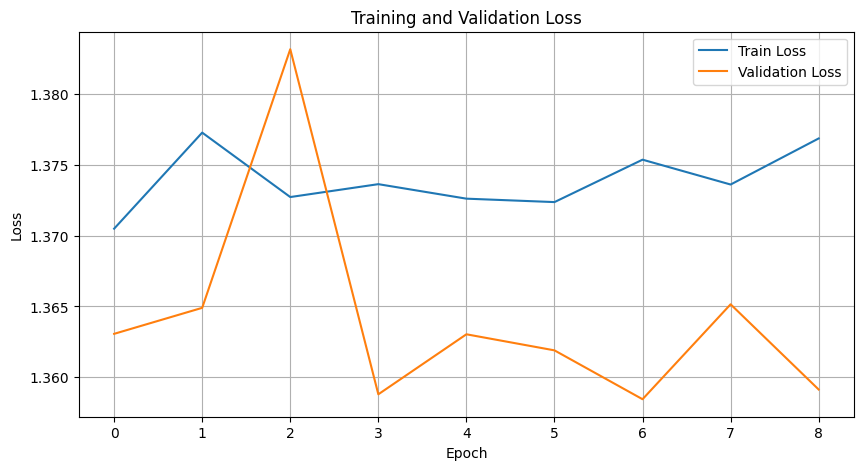

C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Training Accuracy: 75.2819
Training Precision Scores: [75.28189911  0.          0.          0.        ]
Training Recall Scores: [100.   0.   0.   0.]
Training F1 Scores: [85.89808702  0.          0.          0.        ]

Validation Accuracy: 75.0556
Validation Precision Scores: [75.05562973  0.          0.          0.        ]
Validation Recall Scores: [100.   0.   0.   0.]
Validation F1 Scores: [85.75060379  0.          0.          0.        ]

Test Accuracy: 74.9221
Test Precision Scores: [74.92211838  0.          0.          0.        ]
Test Recall Scores: [100.   0.   0.   0.]
Test F1 Scores: [85.6634016  0.         0.         0.       ]



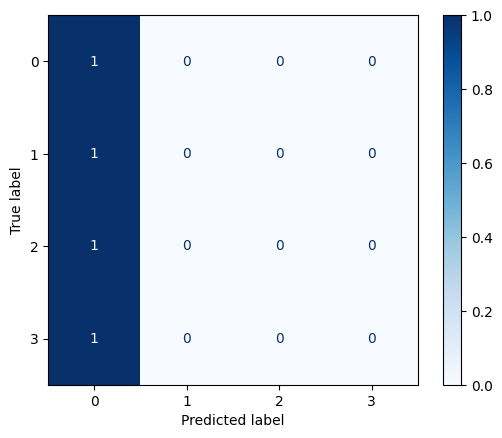

In [31]:
model = DeepNonLinearModel_3(15, 4)
model = model.to(device)
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)  # Computing class weights
class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)  # Converting to PyTorch tensor
criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.05)
num_epochs = 50

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, all_labels_val, all_predictions_val = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, _, _ = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_val, all_predictions_val, normalize='true', cmap='Blues')

# Task 5: Overfitting and Regularization

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.2156, Val Loss: 0.2476
Epoch 40/50, Train Loss: 0.1808, Val Loss: 0.2476
The function took 24.96 seconds to execute.


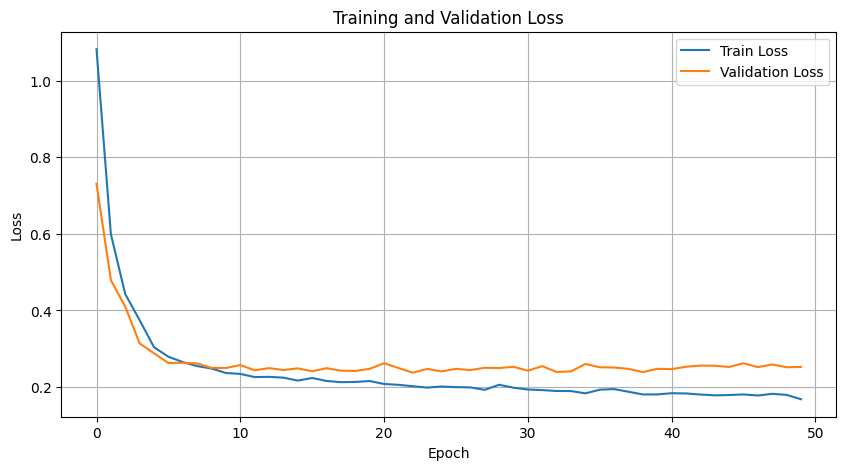

Training Accuracy: 90.3116
Training Precision Scores: [99.43371086 77.57009346 74.9078727  36.51551313]
Training Recall Scores: [88.24398896 94.85714286 97.9413053  87.93103448]
Training F1 Scores: [93.50527305 85.3470437  84.88990129 51.60202361]

Validation Accuracy: 89.8531
Validation Precision Scores: [99.32818273 79.20489297 73.0878187  36.64122137]
Validation Recall Scores: [87.66676549 93.84057971 97.85082174 88.88888889]
Validation F1 Scores: [93.13385827 85.90381426 83.67567568 51.89189189]

Test Accuracy: 90.7210
Test Precision Scores: [99.20265781 78.40236686 75.95682041 40.94488189]
Test Recall Scores: [88.68428868 96.01449275 97.48110831 91.22807018]
Test F1 Scores: [93.64905128 86.31921824 85.38334253 56.52173913]



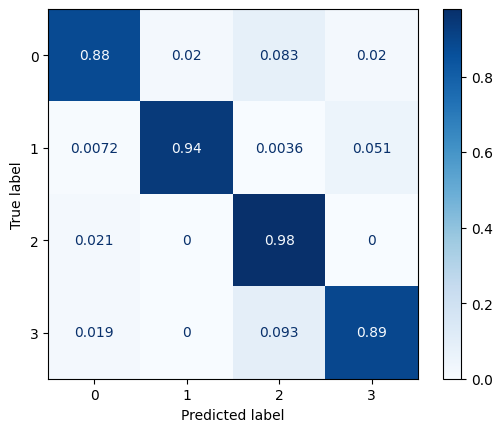

In [32]:
class DeepNonLinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepNonLinearModel, self).__init__()
        self.l1 = nn.Linear(input_size, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64, 32)
        self.l5 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.relu(self.l3(x))
        x = self.relu(self.l4(x))
        x = self.relu(self.l5(x))
        x = self.output_layer(x)
        return x

model = DeepNonLinearModel(15, 4)
model = model.to(device)
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)  # Computing class weights
class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)  # Converting to PyTorch tensor
criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
num_epochs = 50

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs, patience=100)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, all_labels_val, all_predictions_val = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, _, _ = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_val, all_predictions_val, normalize='true', cmap='Blues')

## Dropout

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.3144, Val Loss: 0.2614
Epoch 40/50, Train Loss: 0.2767, Val Loss: 0.2343
The function took 27.83 seconds to execute.


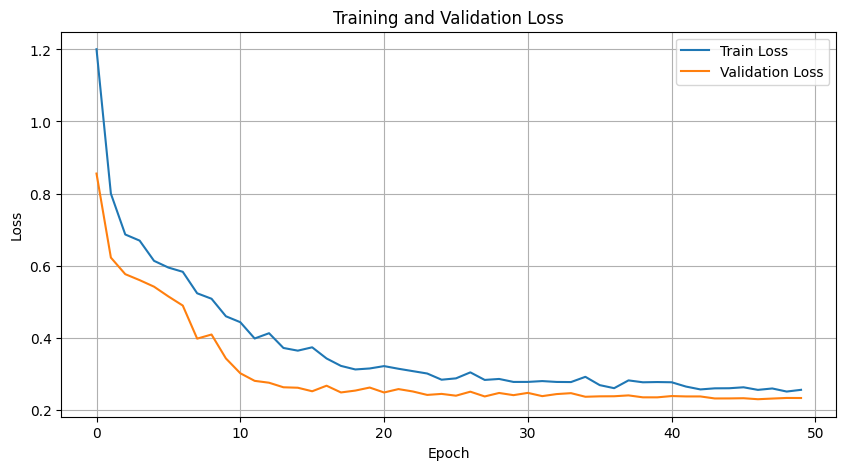

Training Accuracy: 89.7849
Training Precision Scores: [99.47397874 76.66051661 75.16846361 31.03448276]
Training Recall Scores: [87.58376035 94.97142857 97.72229523 87.93103448]
Training F1 Scores: [93.15097207 84.83920368 84.97429061 45.87706147]

Validation Accuracy: 89.2746
Validation Precision Scores: [99.42333786 77.54491018 73.85496183 29.26829268]
Validation Recall Scores: [86.89593833 93.84057971 97.85082174 88.88888889]
Validation F1 Scores: [92.73849075 84.91803279 84.17618271 44.03669725]

Test Accuracy: 90.1647
Test Precision Scores: [99.29577465 77.41935484 76.58102767 32.70440252]
Test Recall Scores: [87.94178794 95.65217391 97.6070529  91.22807018]
Test F1 Scores: [93.27453142 85.57536467 85.82502769 48.14814815]



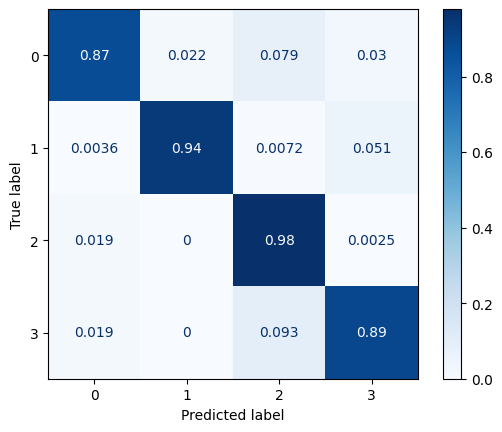

In [33]:
class DeepNonLinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepNonLinearModel, self).__init__()
        self.l1 = nn.Linear(input_size, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64, 32)
        self.l5 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.dropout(x)
        x = self.relu(self.l2(x))
        x = self.dropout(x)
        x = self.relu(self.l3(x))
        x = self.dropout(x)
        x = self.relu(self.l4(x))
        x = self.dropout(x)
        x = self.relu(self.l5(x))
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

model = DeepNonLinearModel(15, 4)
model = model.to(device)
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)  # Computing class weights
class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)  # Converting to PyTorch tensor
criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
num_epochs = 50

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs, patience=100)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, all_labels_val, all_predictions_val = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, _, _ = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_val, all_predictions_val, normalize='true', cmap='Blues')

## Dropout and Batch Normalization

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.3029, Val Loss: 0.2387
Epoch 40/50, Train Loss: 0.2610, Val Loss: 0.2380
The function took 30.39 seconds to execute.


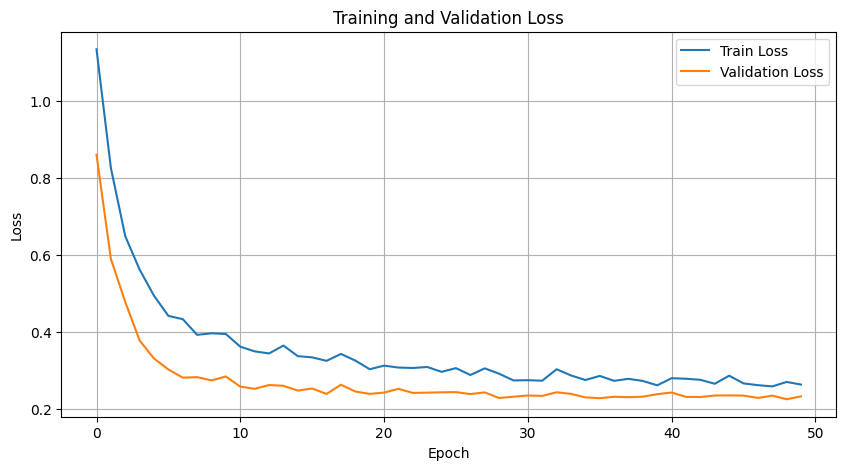

Training Accuracy: 93.7166
Training Precision Scores: [98.21594308 76.73130194 93.07928165 36.69064748]
Training Recall Scores: [93.85100512 94.97142857 93.07928165 87.93103448]
Training F1 Scores: [95.98387503 84.8825332  93.07928165 51.77664975]

Validation Accuracy: 93.8362
Validation Precision Scores: [98.26356589 78.24773414 92.1641791  35.82089552]
Validation Recall Scores: [93.95197154 93.84057971 93.67888748 88.88888889]
Validation F1 Scores: [96.05941194 85.33772652 92.9153605  51.06382979]

Test Accuracy: 94.1700
Test Precision Scores: [98.20489013 78.33827893 92.99123905 40.94488189]
Test Recall Scores: [94.23819424 95.65217391 93.5768262  91.22807018]
Test F1 Scores: [96.18066081 86.13376835 93.28311362 56.52173913]



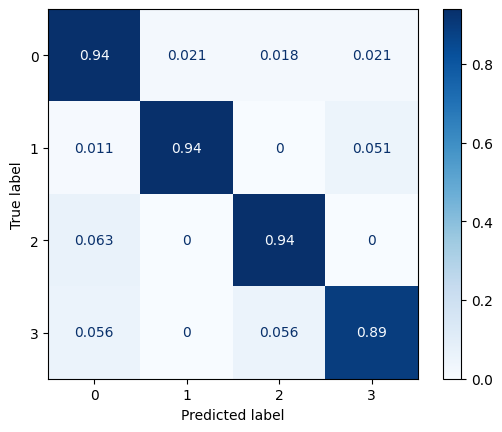

In [34]:
class DeepNonLinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepNonLinearModel, self).__init__()
        self.l1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.l5 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.dropout(x)
        x = self.bn1(x)
        x = self.relu(self.l2(x))
        x = self.dropout(x)
        x = self.relu(self.l3(x))
        x = self.dropout(x)
        x = self.relu(self.l4(x))
        x = self.bn4(x)
        x = self.dropout(x)
        x = self.relu(self.l5(x))
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

model = DeepNonLinearModel(15, 4)
model = model.to(device)
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)  # Computing class weights
class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)  # Converting to PyTorch tensor
criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
num_epochs = 50

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs, patience=100)

train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
val_accuracy, val_precisionscores, val_recallscores, val_f1scores, all_labels_val, all_predictions_val = testing_model(model,val_loader,device)
test_accuracy, test_precisionscores, test_recallscores, test_f1scores, _, _ = testing_model(model,test_loader,device)

stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

ConfusionMatrixDisplay.from_predictions(all_labels_val, all_predictions_val, normalize='true', cmap='Blues')

## AdamW's weight decay

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.3334, Val Loss: 0.2676
Epoch 40/50, Train Loss: 0.2727, Val Loss: 0.2378
The function took 31.16 seconds to execute.


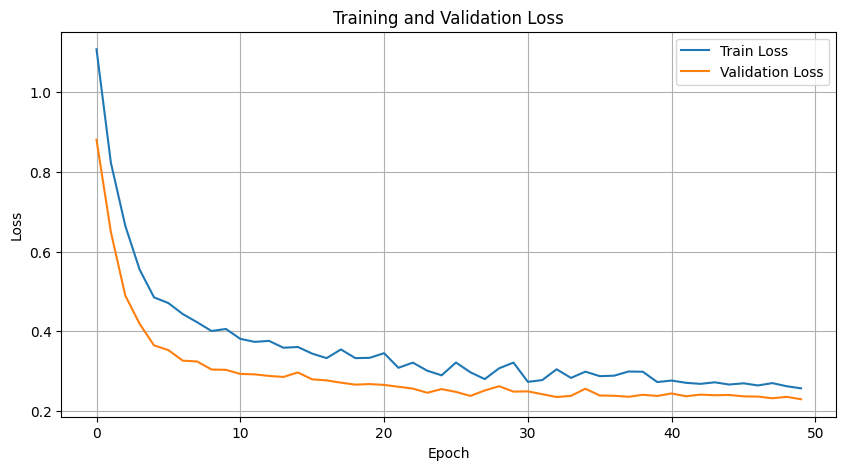

Training Accuracy: 91.4466
Training Precision Scores: [99.37847563 75.33998187 80.5856833  34.77272727]
Training Recall Scores: [89.81080016 94.97142857 97.6346912  87.93103448]
Training F1 Scores: [94.35270977 84.02426694 88.29471182 49.83713355]

Validation Accuracy: 91.0102
Validation Precision Scores: [99.30715935 74.28571429 79.09836066 35.03649635]
Validation Recall Scores: [89.238067   94.20289855 97.59797724 88.88888889]
Validation F1 Scores: [94.00374766 83.06709265 87.37973967 50.2617801 ]

Test Accuracy: 92.0116
Test Precision Scores: [99.18566775 76.52173913 82.34042553 37.41007194]
Test Recall Scores: [90.43659044 95.65217391 97.48110831 91.22807018]
Test F1 Scores: [94.60929004 85.02415459 89.2733564  53.06122449]



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.2939, Val Loss: 0.2394
Epoch 40/50, Train Loss: 0.2876, Val Loss: 0.2329
The function took 30.57 seconds to execute.


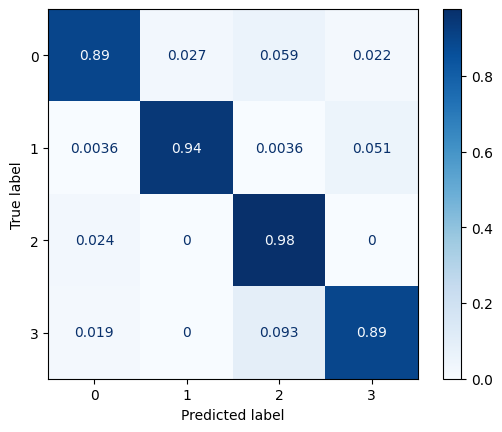

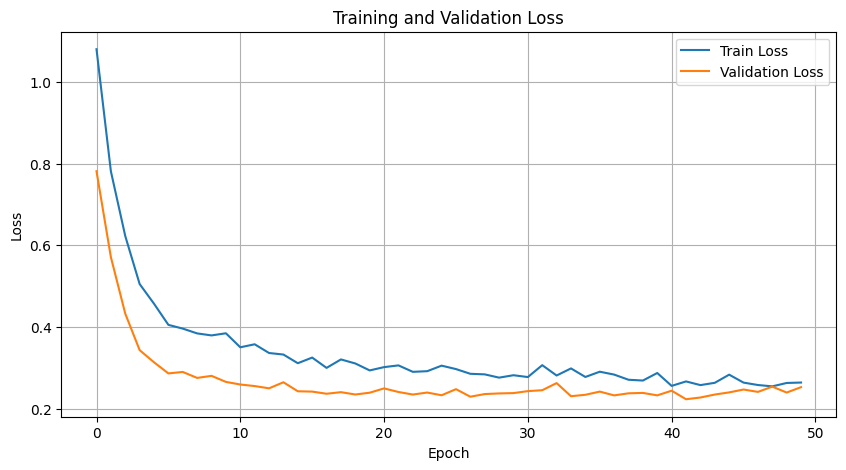

Training Accuracy: 91.1795
Training Precision Scores: [99.36535726 76.02927722 84.0030326  26.72131148]
Training Recall Scores: [89.48561293 94.97142857 97.065265   93.67816092]
Training F1 Scores: [94.16705553 84.45121951 90.06299533 41.58163265]

Validation Accuracy: 91.0102
Validation Precision Scores: [99.27488464 77.08333333 82.79569892 25.25773196]
Validation Recall Scores: [89.2973614  93.84057971 97.34513274 90.74074074]
Validation F1 Scores: [94.02216326 84.64052288 89.4828588  39.51612903]

Test Accuracy: 91.6778
Test Precision Scores: [99.18193717 77.19298246 84.72527473 29.03225806]
Test Recall Scores: [90.02079002 95.65217391 97.10327456 94.73684211]
Test F1 Scores: [94.37957341 85.4368932  90.49295775 44.44444444]



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.3135, Val Loss: 0.2340
Epoch 40/50, Train Loss: 0.2861, Val Loss: 0.2349
The function took 30.41 seconds to execute.


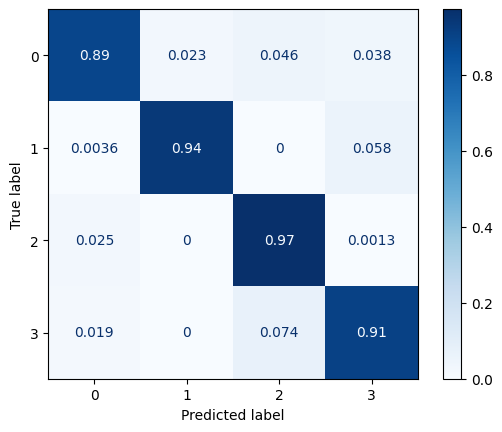

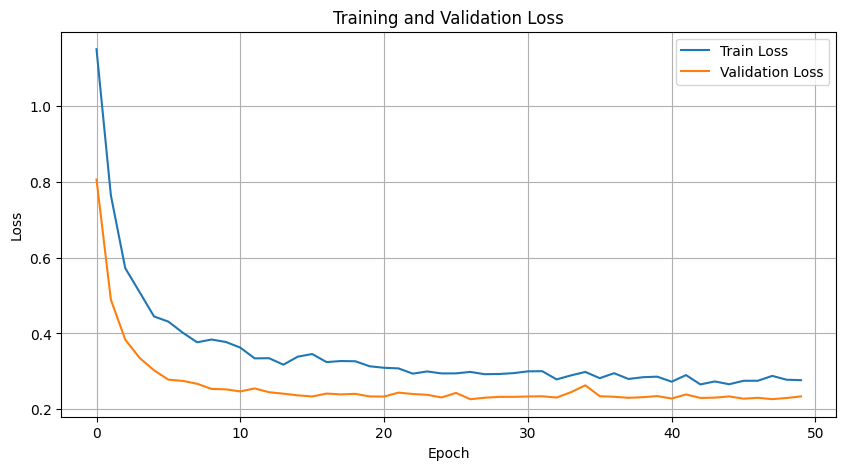

Training Accuracy: 91.0757
Training Precision Scores: [99.32292235 74.28571429 84.18013857 26.94214876]
Training Recall Scores: [89.62357115 95.08571429 95.79500657 93.67816092]
Training F1 Scores: [94.22429422 83.4085213  89.61278427 41.84852375]

Validation Accuracy: 90.6765
Validation Precision Scores: [99.24167491 73.37110482 81.81818182 27.17391304]
Validation Recall Scores: [89.238067   93.84057971 95.57522124 92.59259259]
Validation F1 Scores: [93.974399   82.35294118 88.16326531 42.01680672]

Test Accuracy: 91.7000
Test Precision Scores: [99.11994785 74.78753541 84.32671082 31.13772455]
Test Recall Scores: [90.31779032 95.65217391 96.22166247 91.22807018]
Test F1 Scores: [94.51437451 83.9427663  89.88235294 46.42857143]



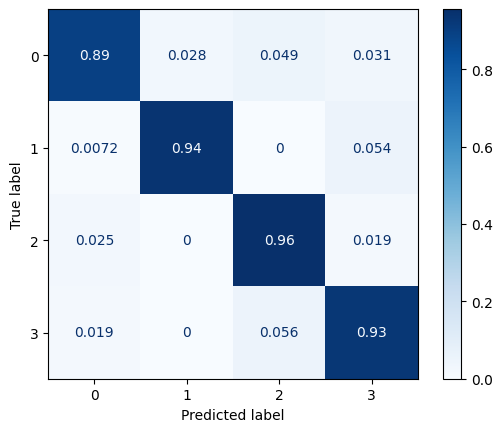

In [35]:
class DeepNonLinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepNonLinearModel, self).__init__()
        self.l1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.l5 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.dropout(x)
        x = self.bn1(x)
        x = self.relu(self.l2(x))
        x = self.dropout(x)
        x = self.relu(self.l3(x))
        x = self.dropout(x)
        x = self.relu(self.l4(x))
        x = self.bn4(x)
        x = self.dropout(x)
        x = self.relu(self.l5(x))
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

for weight_decay in [0.0001, 0.0005, 0.0010]:
    model = DeepNonLinearModel(15, 4)
    model = model.to(device)
    class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)  # Computing class weights
    class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)  # Converting to PyTorch tensor
    criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=weight_decay)
    num_epochs = 50

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs, patience=100)

    train_accuracy, train_precisionscores, train_recallscores, train_f1scores, _, _ = testing_model(model,train_loader,device)
    val_accuracy, val_precisionscores, val_recallscores, val_f1scores, all_labels_val, all_predictions_val = testing_model(model,val_loader,device)
    test_accuracy, test_precisionscores, test_recallscores, test_f1scores, _, _ = testing_model(model,test_loader,device)

    stats(train_accuracy, train_precisionscores, train_recallscores, train_f1scores, 'Training')
    stats(val_accuracy, val_precisionscores, val_recallscores, val_f1scores, 'Validation')
    stats(test_accuracy, test_precisionscores, test_recallscores, test_f1scores, 'Test')

    ConfusionMatrixDisplay.from_predictions(all_labels_val, all_predictions_val, normalize='true', cmap='Blues')